# COMP9414 Project 1
## z5499630 Boyang, Peng


In this project, I will be working on time series prediction using neural network architectures, focusing on both classification and estimation tasks using a modified "Air Quality" dataset. The dataset contains hourly averaged responses from chemical sensors embedded in an air quality device, with recorded data from March 2004 to February 2005.

## Activities

### Classification Task

#TODO:

Develop a neural network to predict if the concentration of Carbon Monoxide (CO) exceeds the mean of CO(GT) values.
Perform binary classification to categorize instances as above or below the threshold.
Handle missing values in the dataset.

### Regression Task

#TODO:

Develop a neural network to predict the concentration of Nitrogen Oxides (NOx) based on other air quality features.
Estimate a continuous numerical value using regression techniques.
Handle missing values in the dataset.


## Data Preproccessing

### Step 1: Loading Data from files

In [1]:
# z5499630 Boyang, Peng

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import tensorflow as tf
import seaborn as sns
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Input
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l2

# Read data from the given xlsx file
AQ_file = 'AirQualityUCI _ Students.xlsx'
AQ_data = pd.read_excel(AQ_file)

### Step 2: Identify variation range for input and output variables [Answering 2.1 (a)]

In [2]:
# Calculate the minimum and maximum values of each column and create a DataFrame to display the results
min_max_df = pd.DataFrame({'Min': AQ_data.min(), 'Max': AQ_data.max()})

print(min_max_df)
# min_max_df

                               Min                  Max
Date           2004-03-10 00:00:00  2005-04-01 00:00:00
Time                      00:00:00             23:00:00
CO(GT)                      -200.0                 11.9
PT08.S1(CO)                 -200.0              2007.75
NMHC(GT)                      -200                 1189
C6H6(GT)                    -200.0            63.741476
PT08.S2(NMHC)               -200.0               2214.0
NOx(GT)                     -200.0               1479.0
PT08.S3(NOx)                -200.0              2682.75
NO2(GT)                     -200.0                339.7
PT08.S4(NO2)                -200.0               2775.0
PT08.S5(O3)                 -200.0              2522.75
T                           -200.0                 44.6
RH                          -200.0            87.174999
AH                          -200.0             2.231036


### Step 3: Convert and Set Date Index

In [3]:
# Convert Date column to datetime
AQ_data['Date'] = pd.to_datetime(AQ_data['Date'])

# Set Date as the index
AQ_data.set_index('Date', inplace=True)

# Drop the Time column
AQ_data.drop(columns=['Time'], inplace=True)

### Step 4: Ploting each variable to observe the overall behaviour of the process [Answering 2.1 (b)]

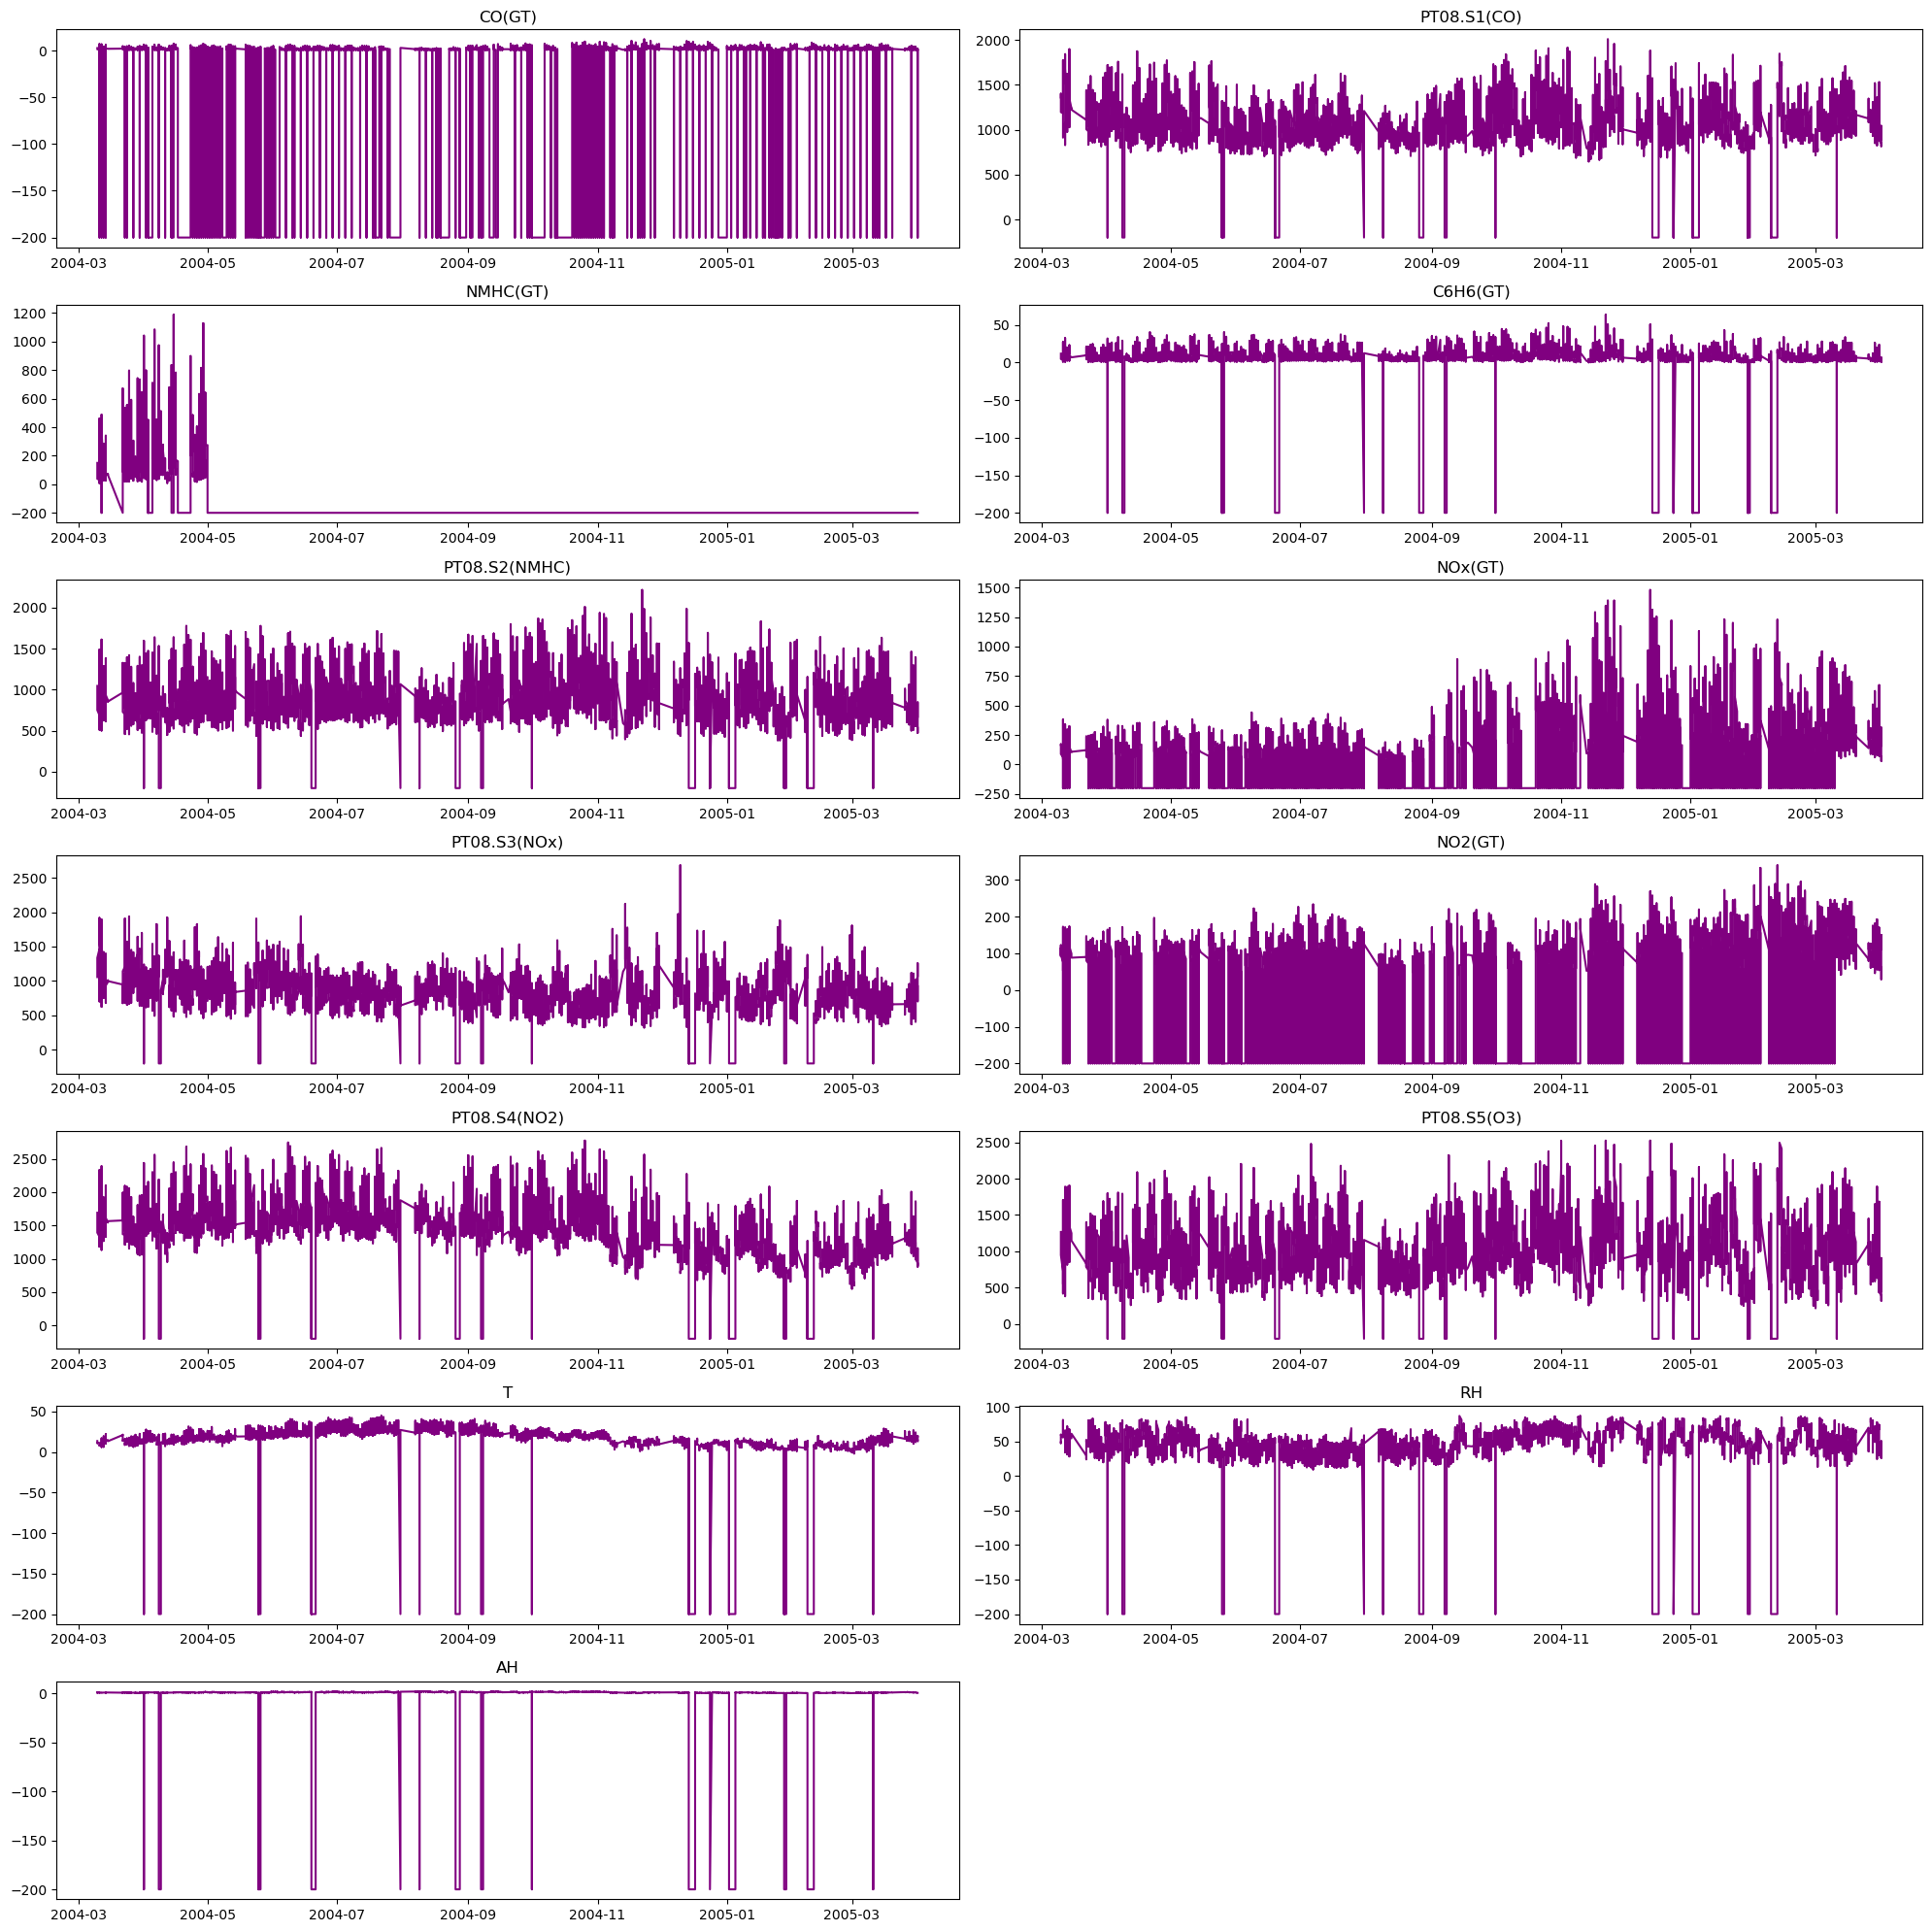

In [4]:
# Calculate the number of rows needed to fit all subplots in 2 columns for compact view
nrows = (len(AQ_data.columns) + 1) // 2

fig, axes = plt.subplots(nrows=nrows, ncols=2, figsize=(20, 20))
axes = axes.flatten()

for i, column in enumerate(AQ_data.columns):
    axes[i].plot(AQ_data.index, AQ_data[column], color='purple')
    axes[i].set_title(column)

for j in range(i+1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

### Step 5: Handle Missing Values [Answering 2.1 (c)]

#### Since stated in the Problem context, the missing value has been tagget with -200. Hence, replace -200 with NaN for missing data in the plots above
#### Count the occurrences of -200 in each column

Tally of missing value (-200):
CO(GT)           1585
PT08.S1(CO)       366
NMHC(GT)         7525
C6H6(GT)          366
PT08.S2(NMHC)     366
NOx(GT)          1573
PT08.S3(NOx)      366
NO2(GT)          1576
PT08.S4(NO2)      366
PT08.S5(O3)       366
T                 366
RH                366
AH                366
dtype: int64


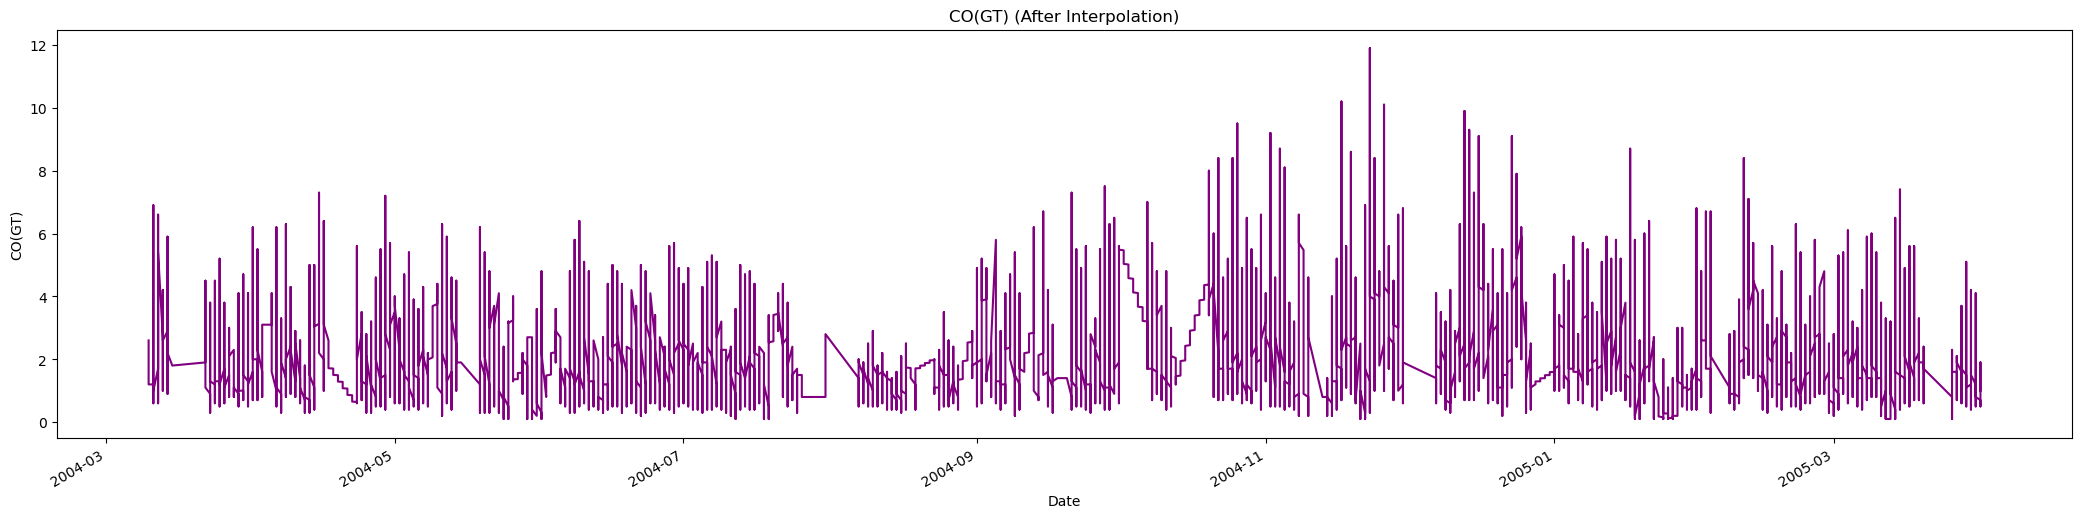

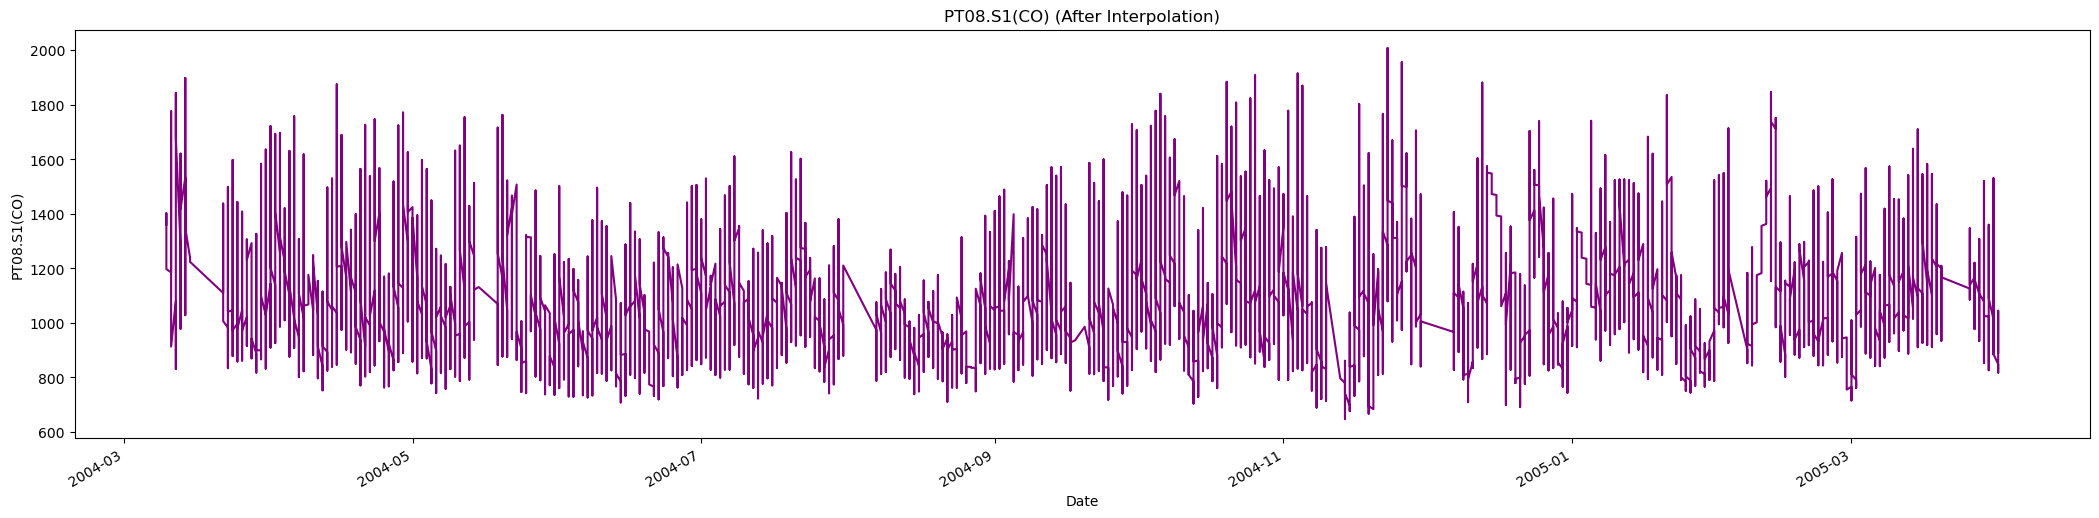

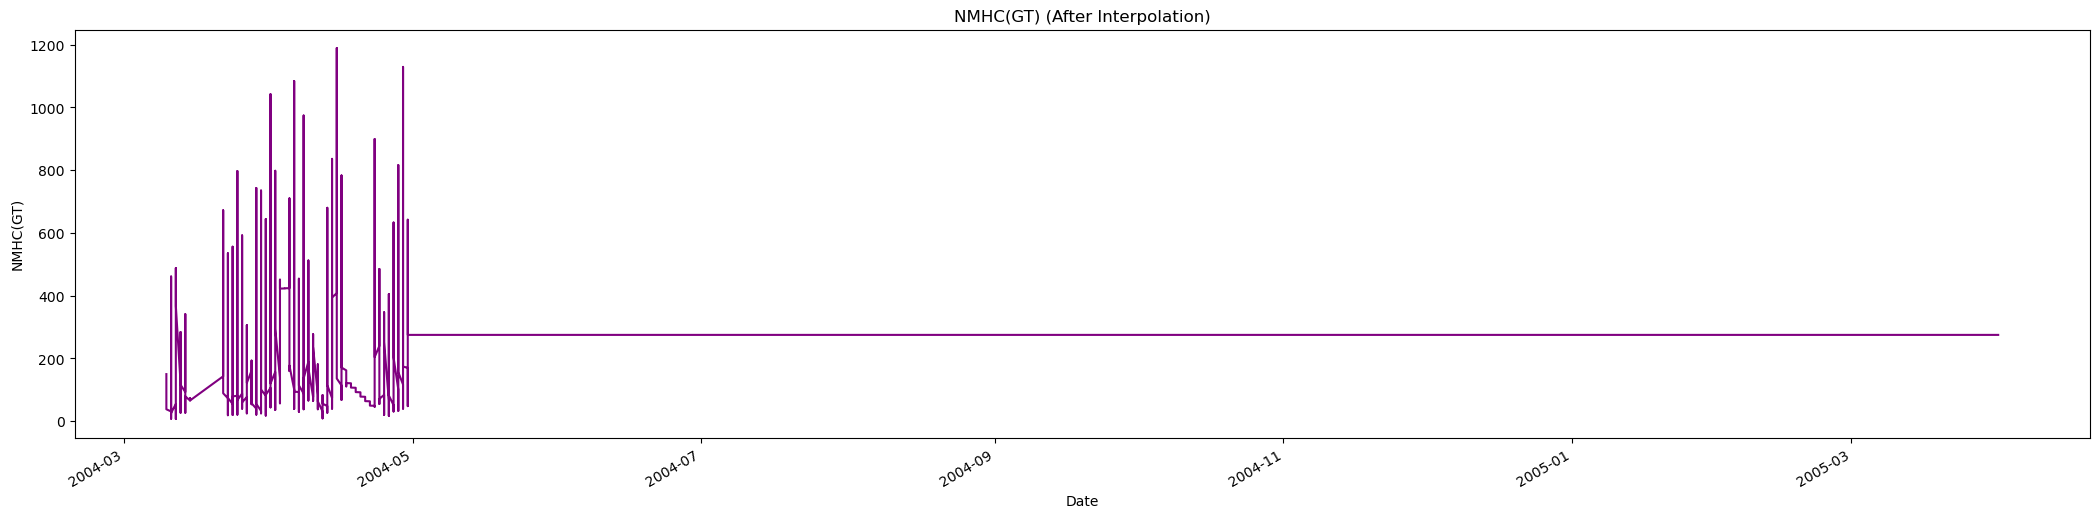

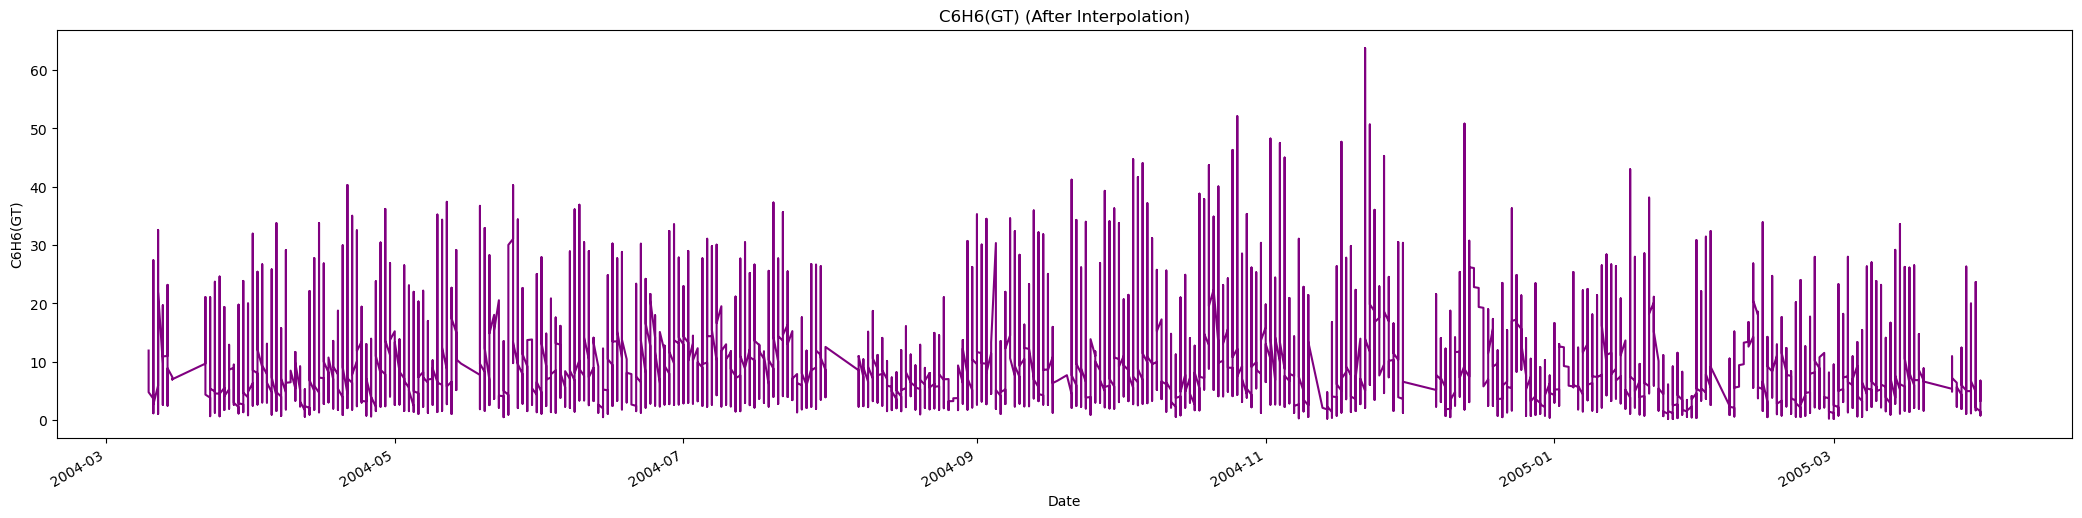

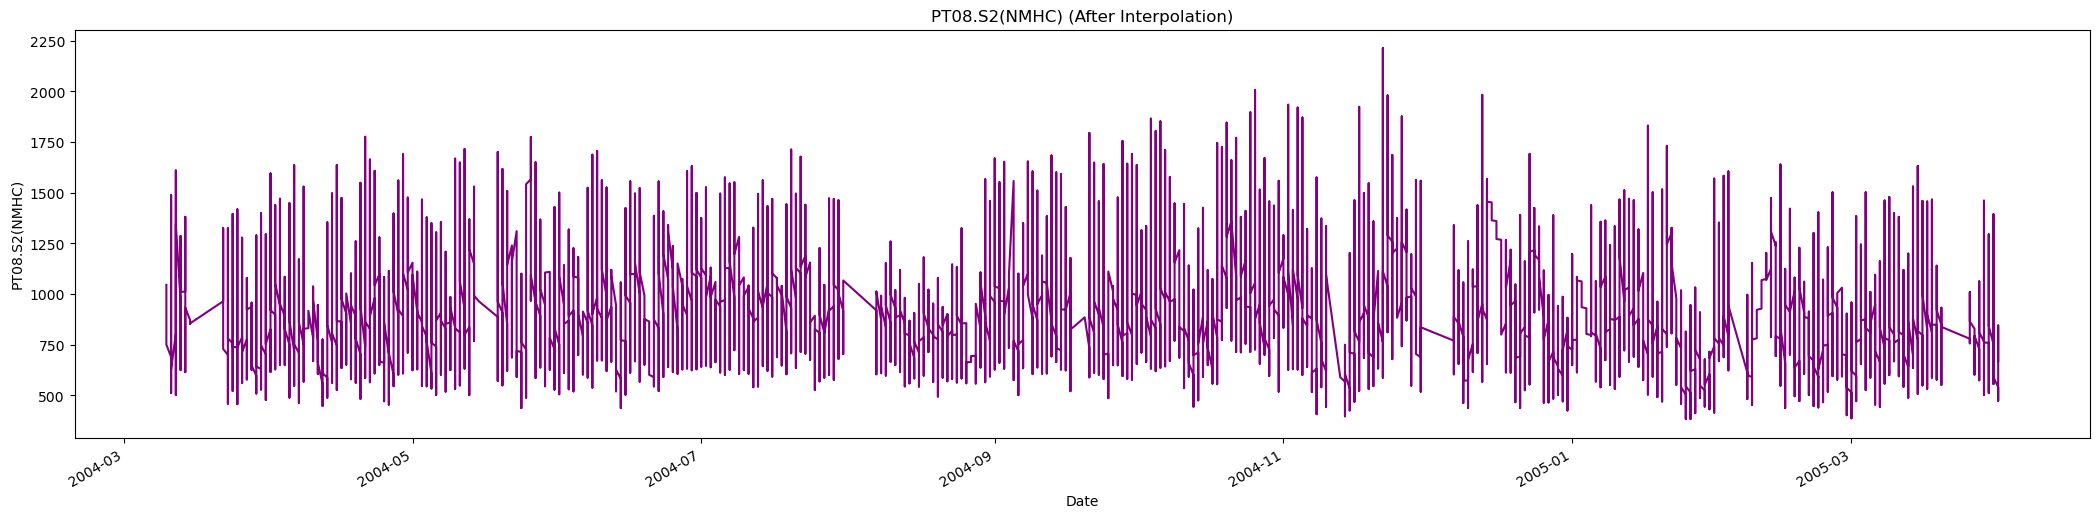

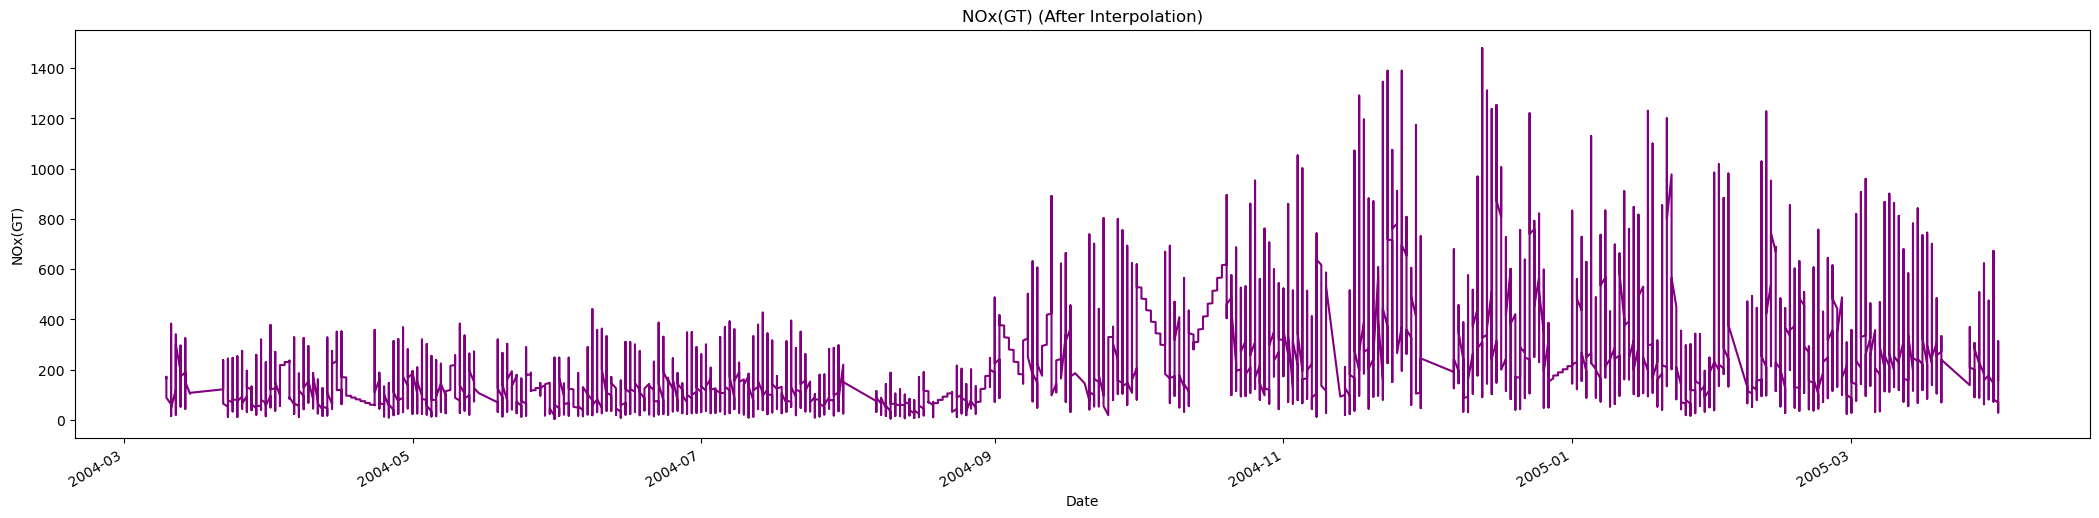

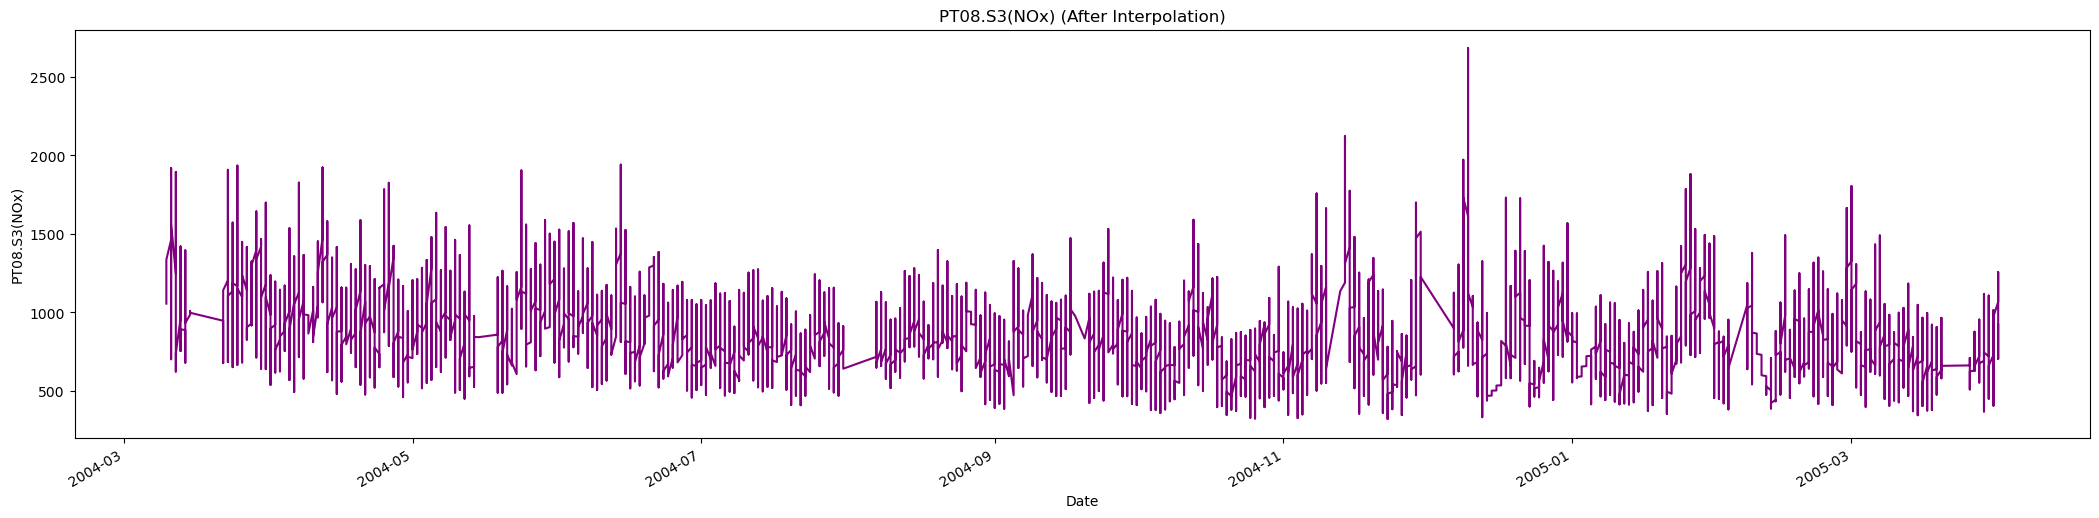

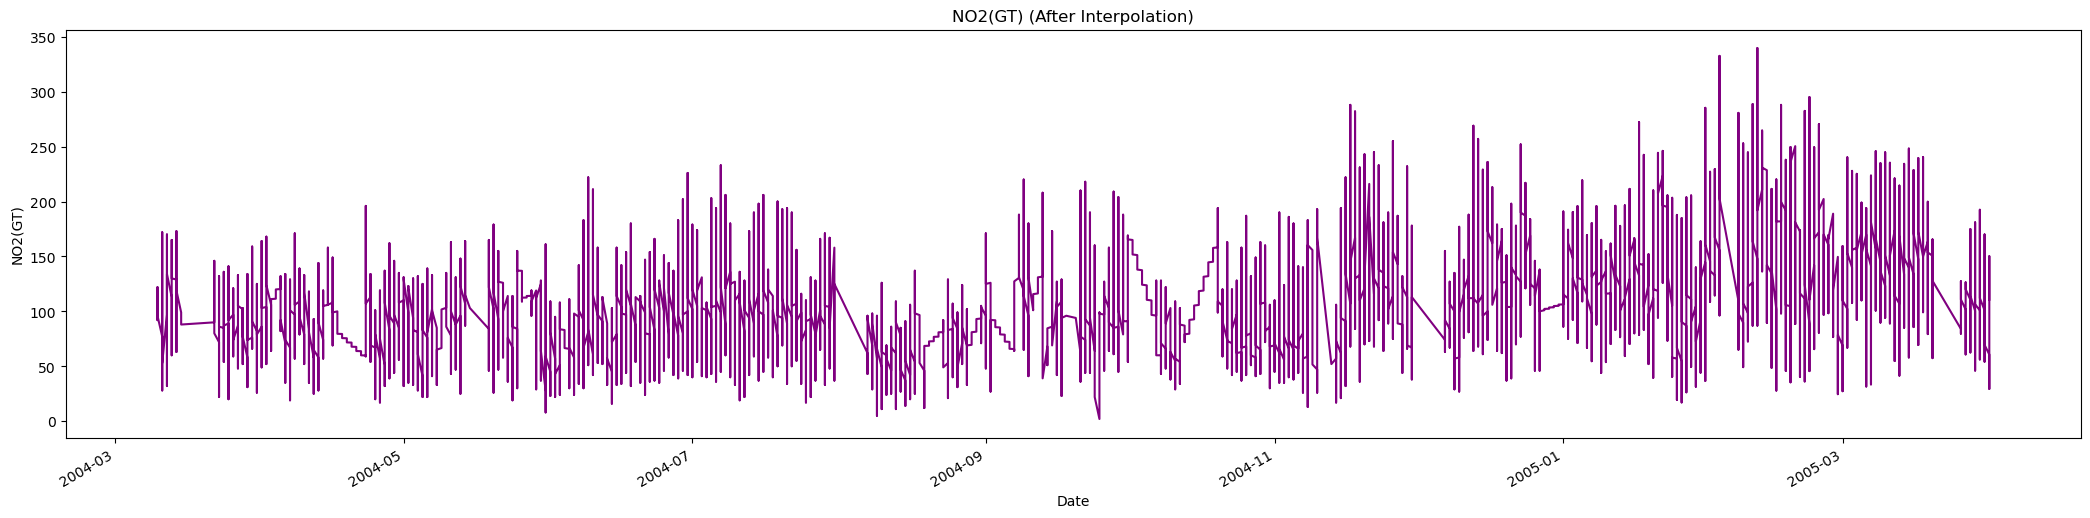

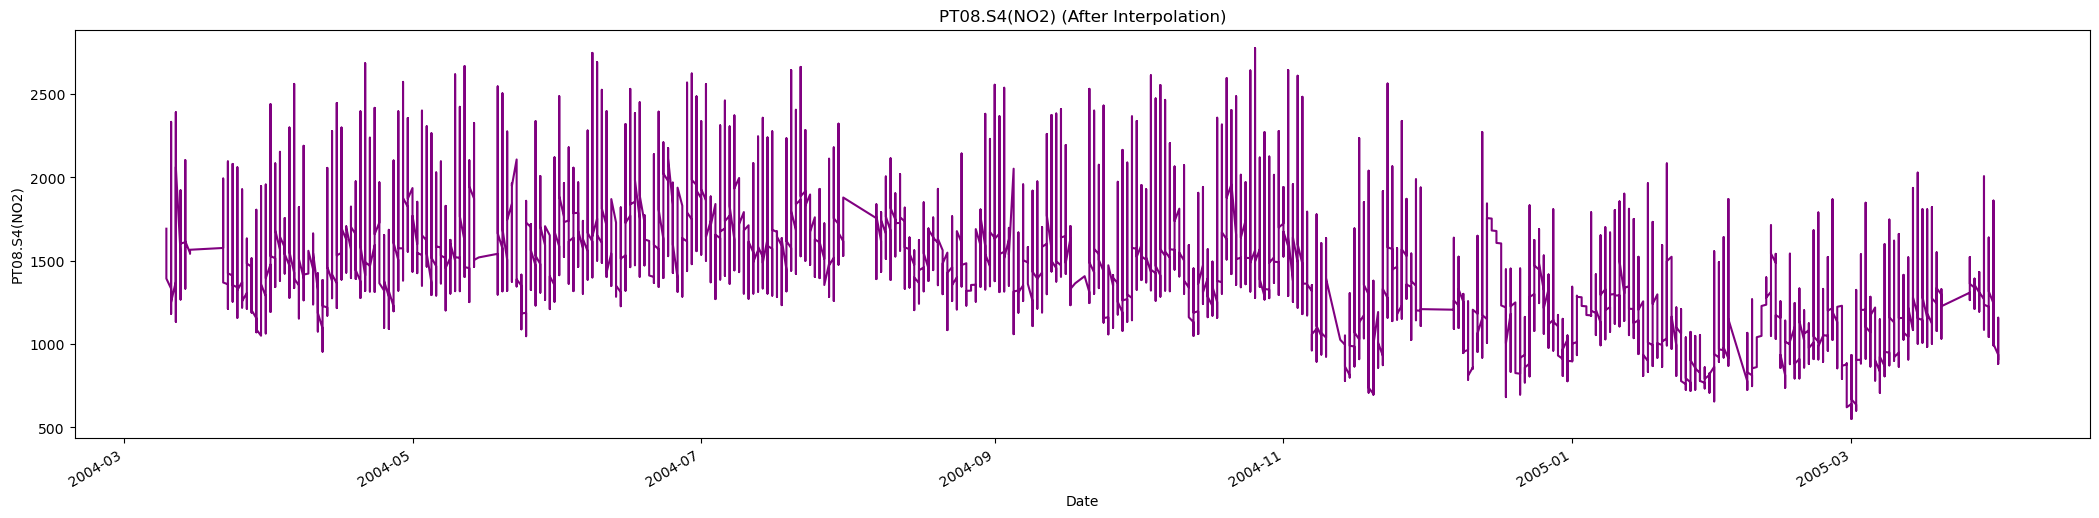

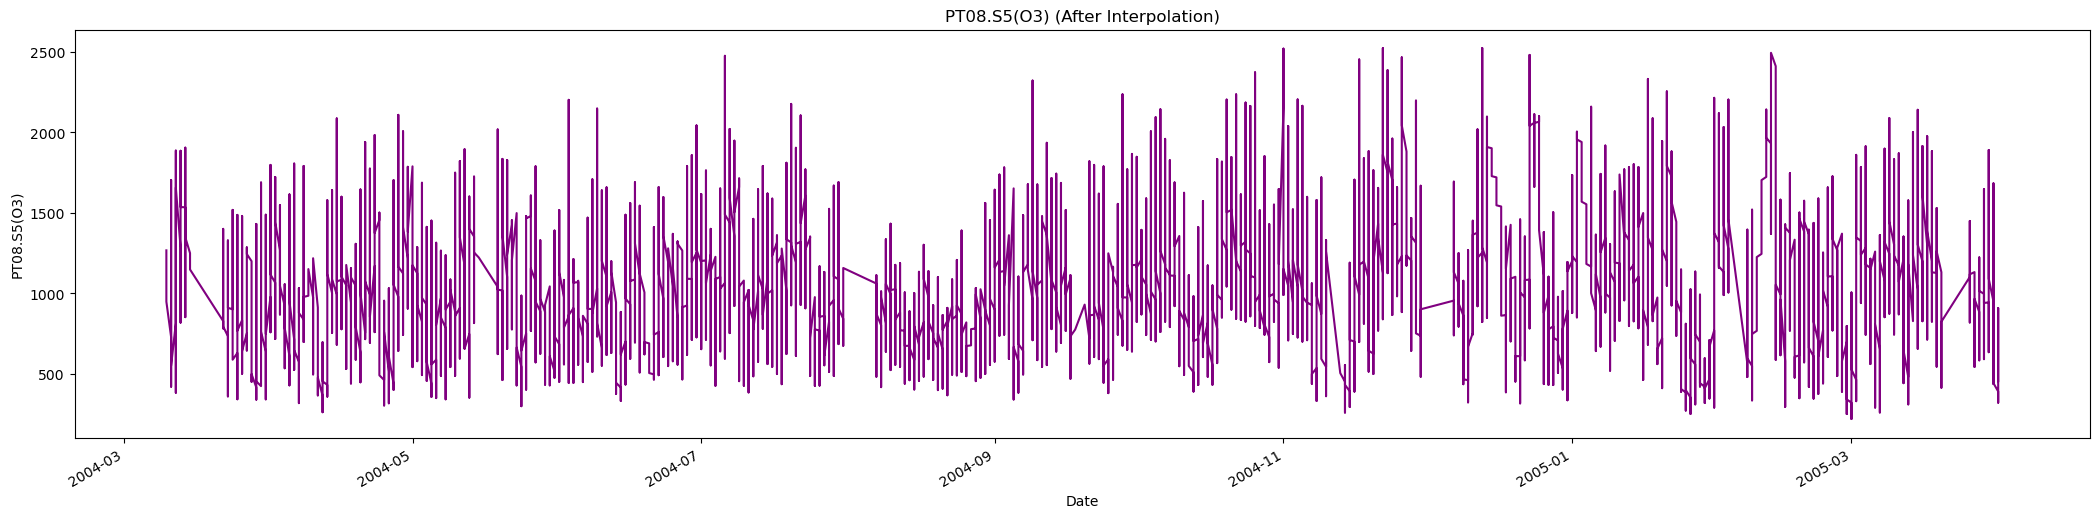

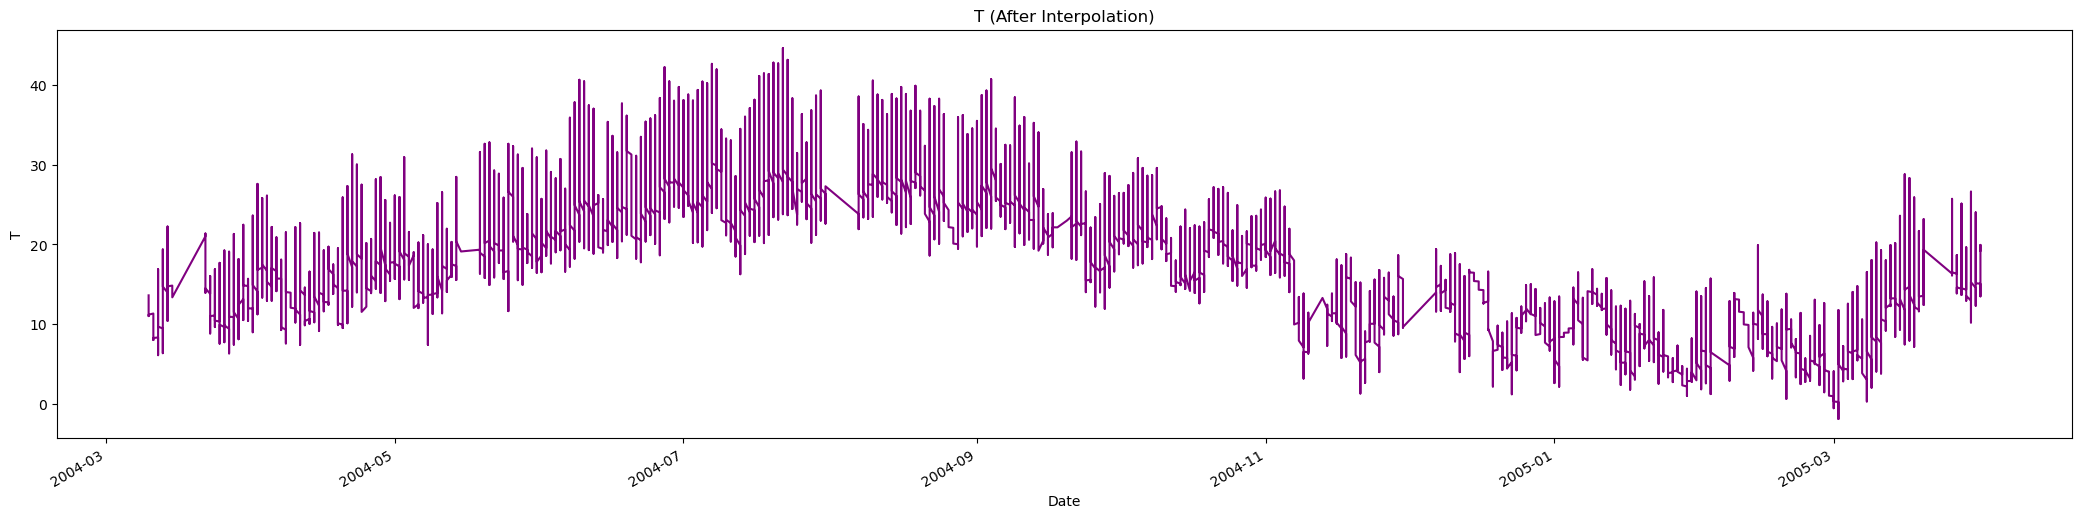

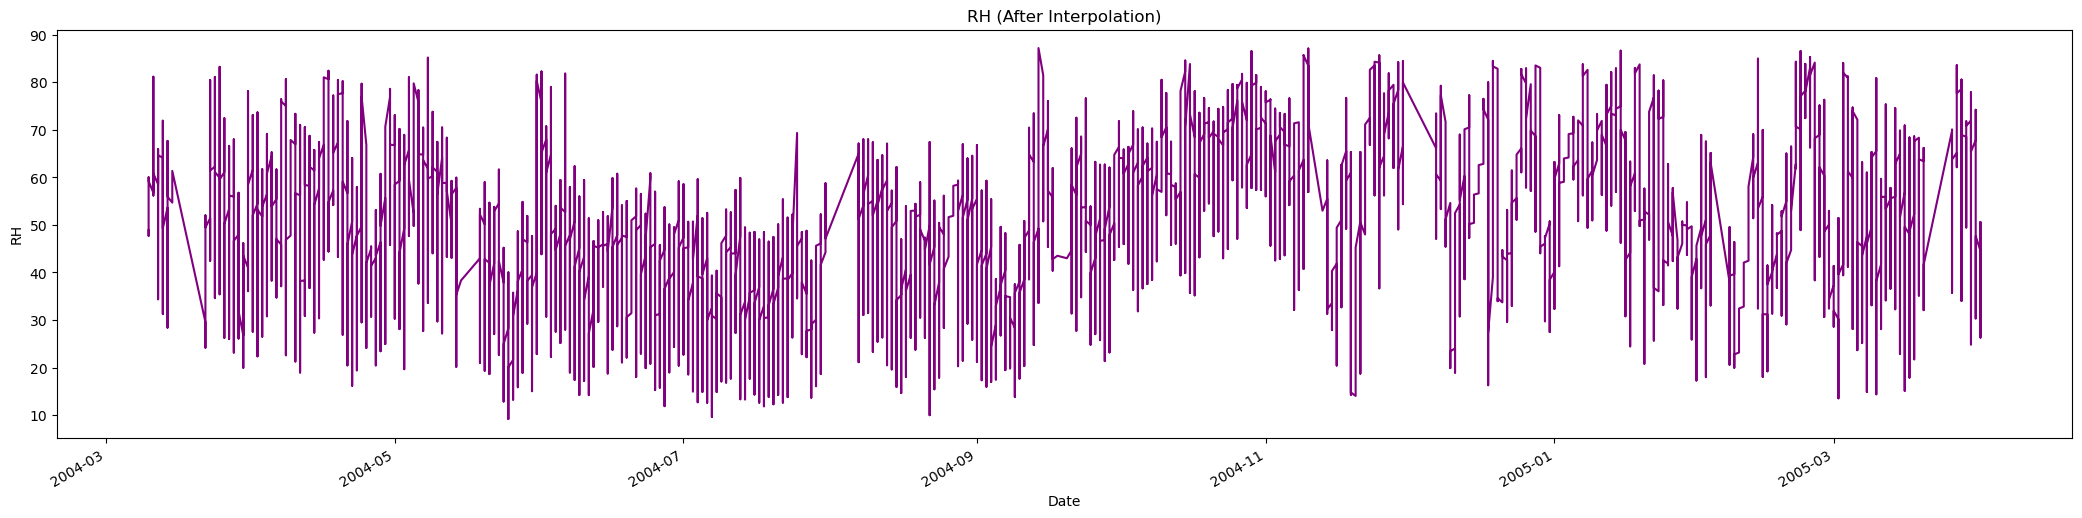

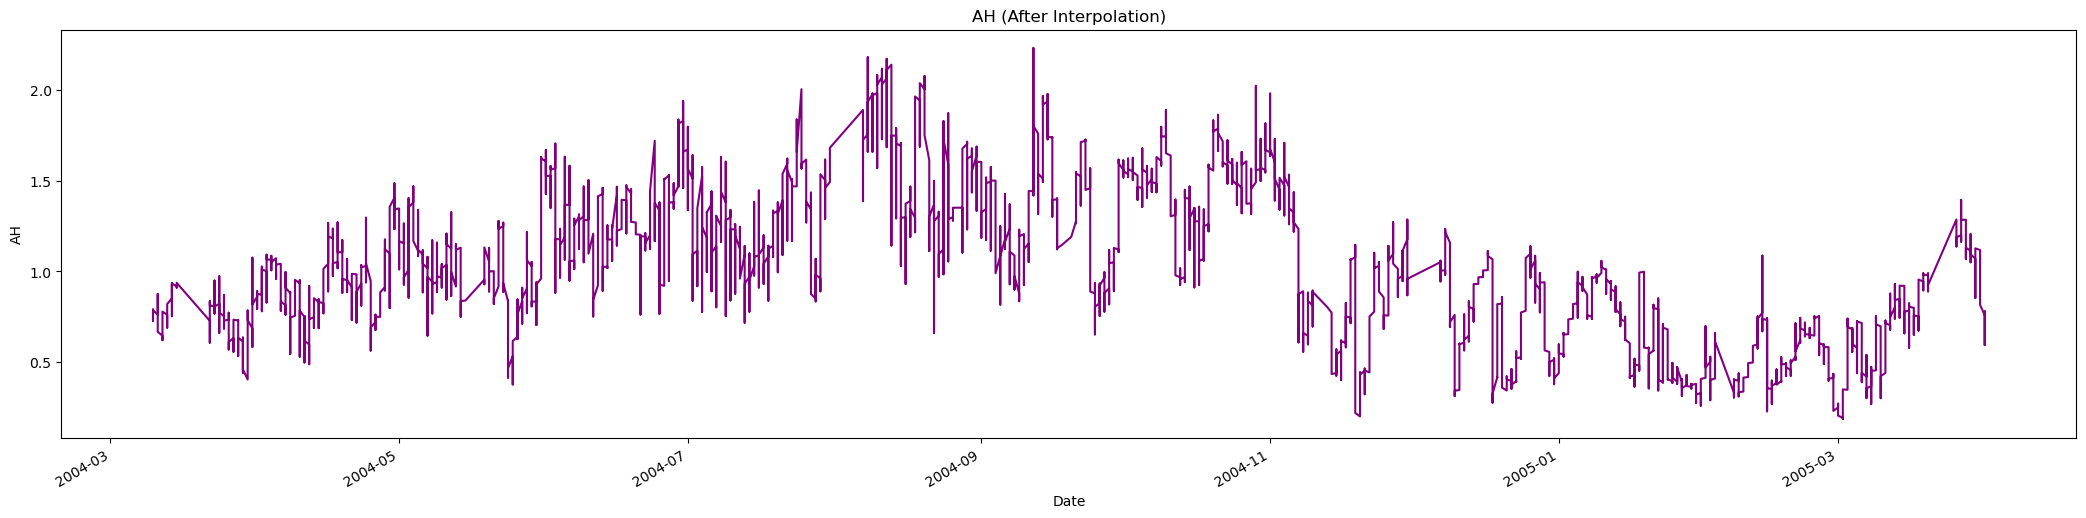

In [5]:
# Checking missing value
missing_value_tally = (AQ_data == -200).sum()
print("Tally of missing value (-200):")
print(missing_value_tally)

# Replace the missing value with NaN
data_replaced = AQ_data.replace(-200, np.nan)

# Handle missing data using linear interpolation
data_interpolated = data_replaced.interpolate(method='linear', limit_direction='forward', axis=0)

# Plot data after interpolation
for column in data_interpolated.columns:
    plt.figure(figsize=(26, 6))
    data_interpolated[column].plot(title=f'{column} (After Interpolation)', color='purple')
    plt.xlabel('Date')
    plt.ylabel(column)
    plt.show()

### Step 6: Detect and Handle Outliers [Answering 2.1 (c) cont.]

In descriptive statistics, the interquartile range (IQR) is a measure of statistical dispersion, which is the spread of the data.
It is defined as the difference between the 75th and 25th percentiles of the data.
To calculate the IQR, the data set is divided into quartiles, or four rank-ordered even parts via linear interpolation.
These quartiles are denoted by Q1 (also called the lower quartile), Q2 (the median), and Q3 (also called the upper quartile). `The lower quartile corresponds with the 25th percentile and the upper quartile corresponds with the 75th percentile`, so `IQR = Q3 −  Q1`.
The IQR is an example of a trimmed estimator, defined as the 25% trimmed range, which enhances the accuracy of dataset statistics by dropping lower contribution, outlying points.[1]


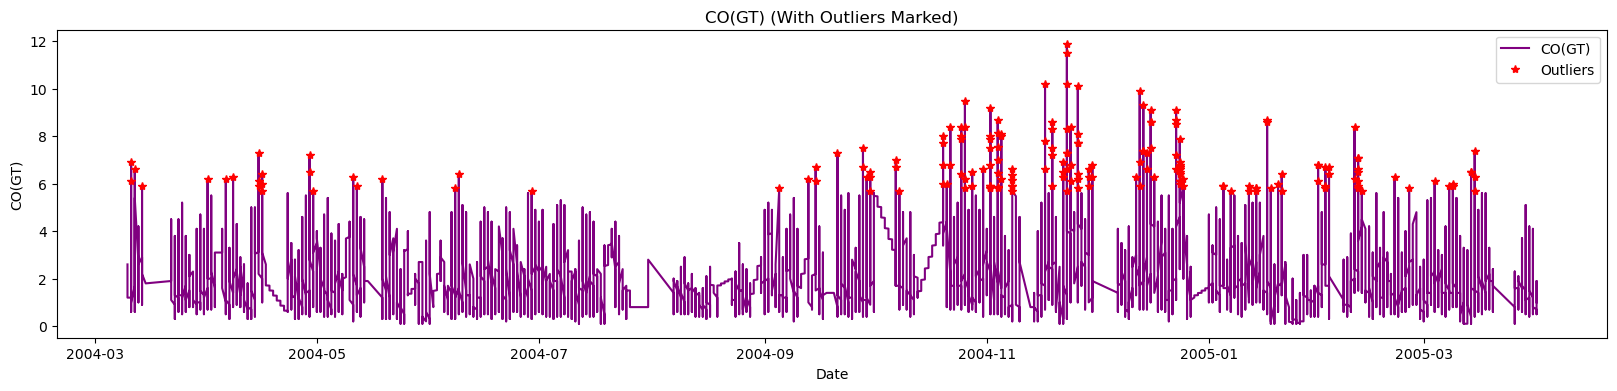

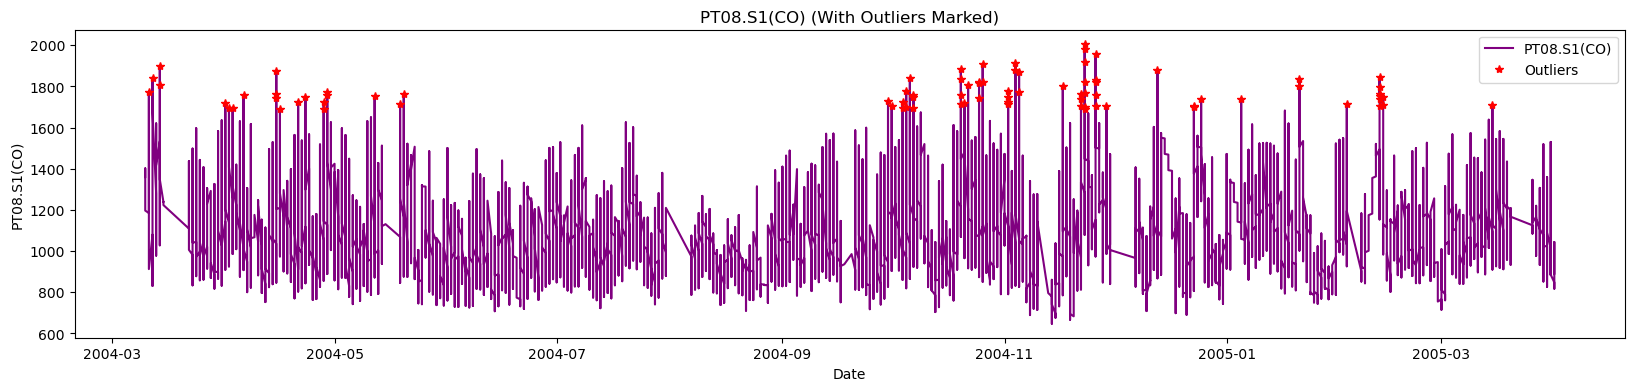

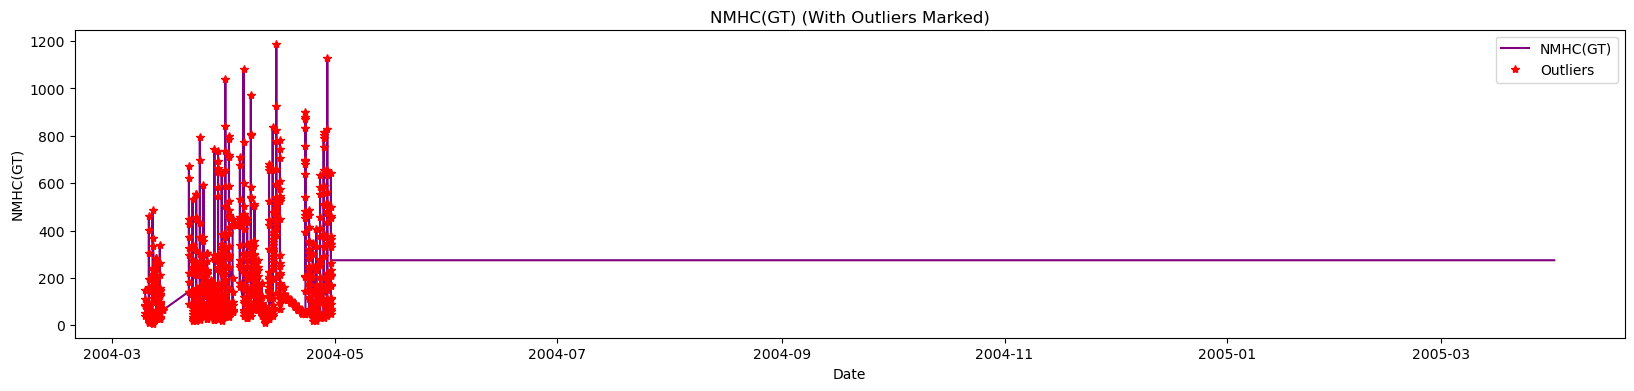

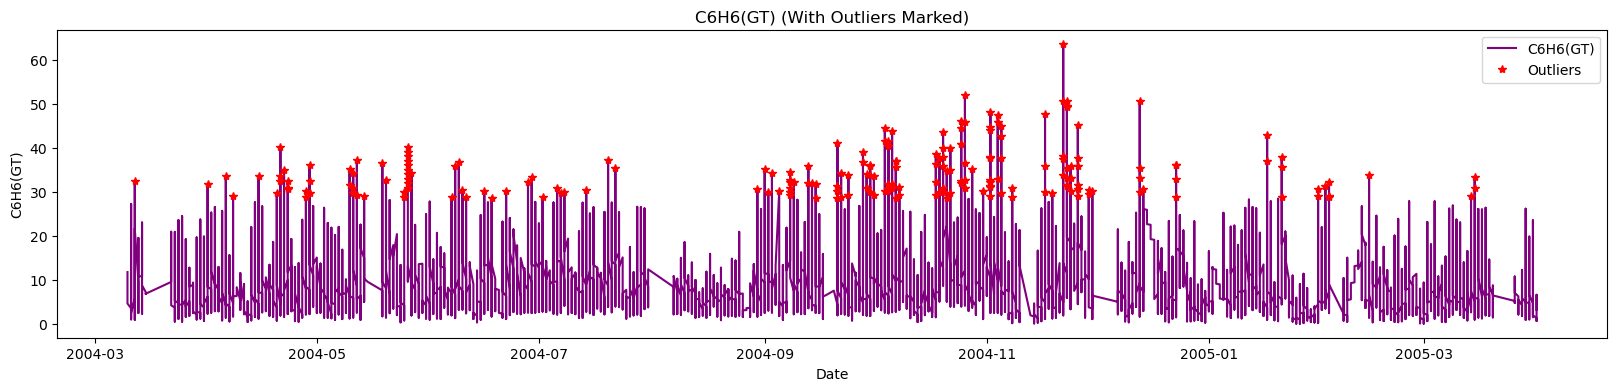

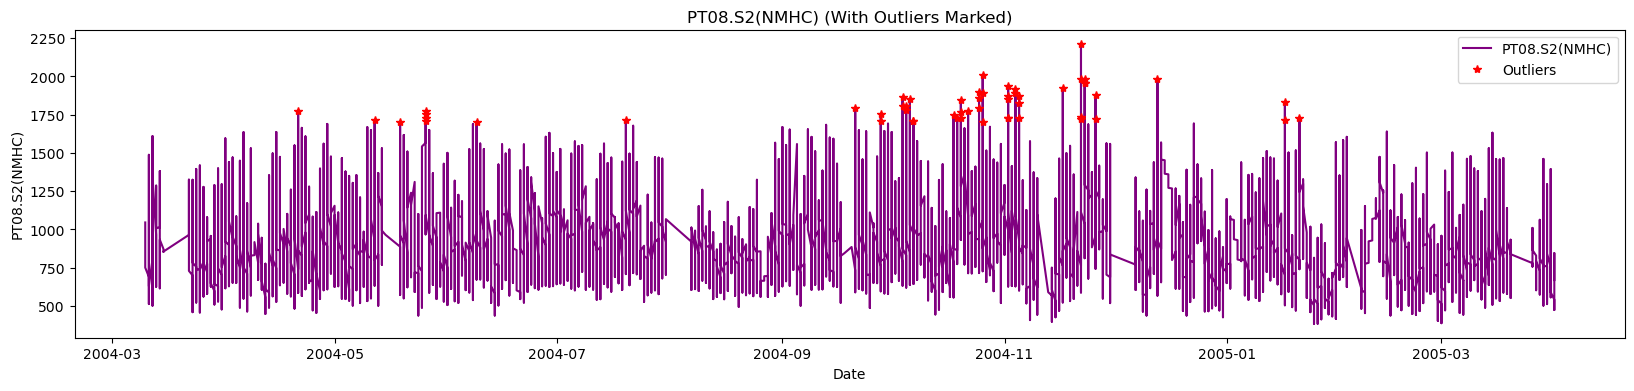

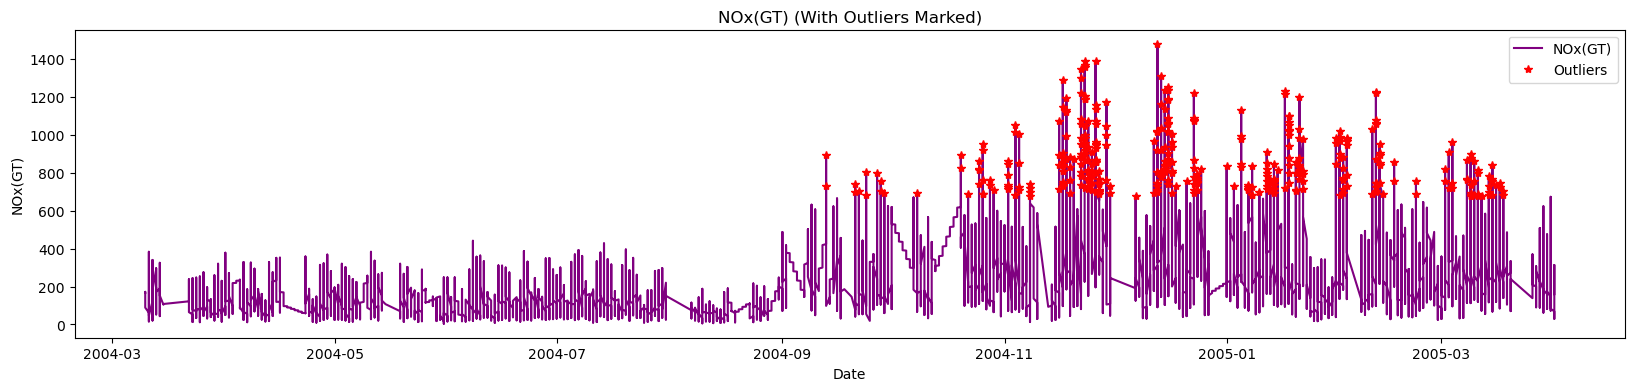

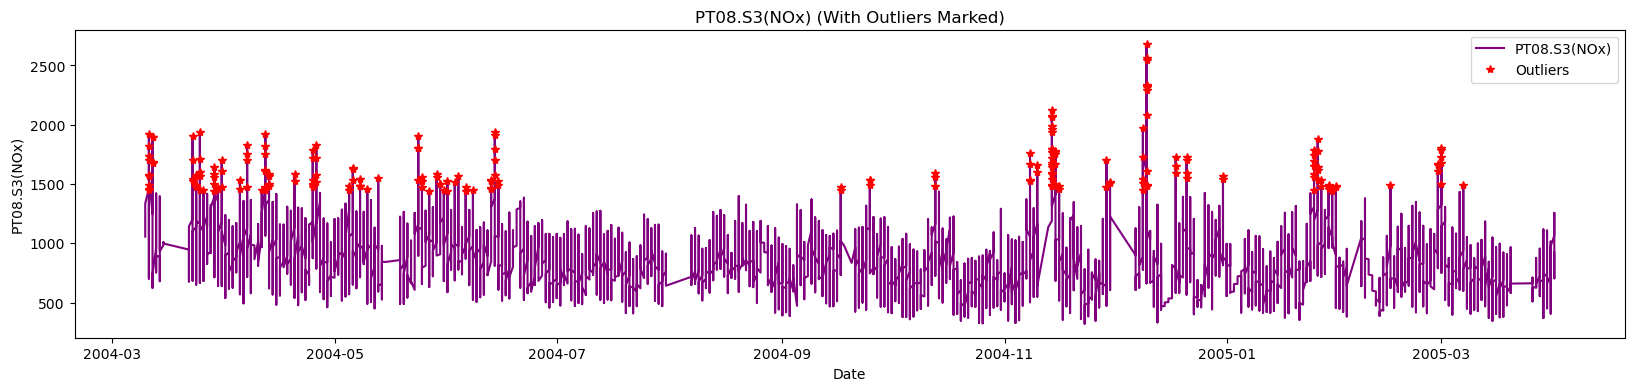

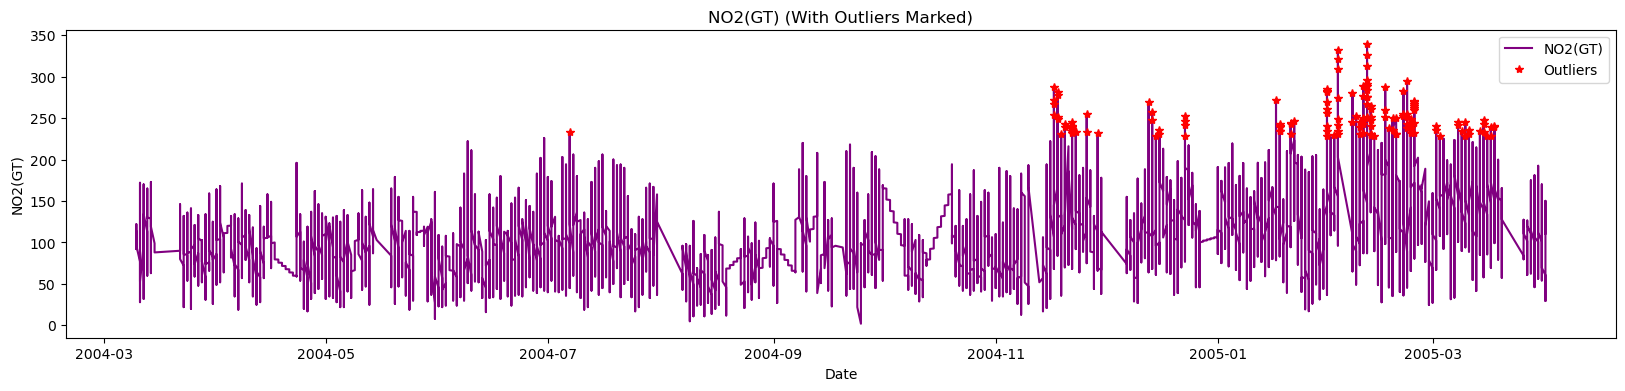

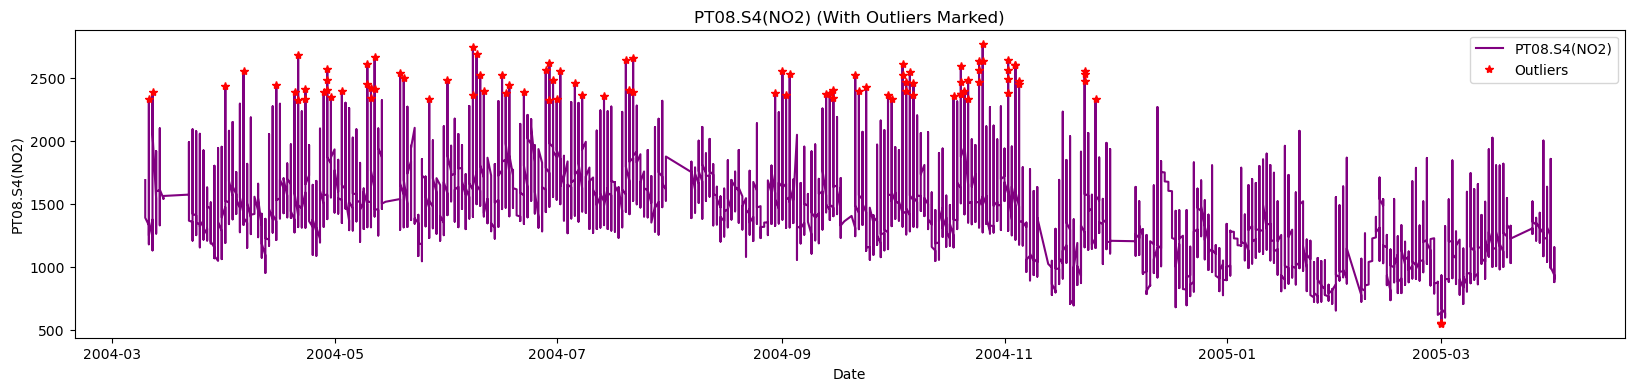

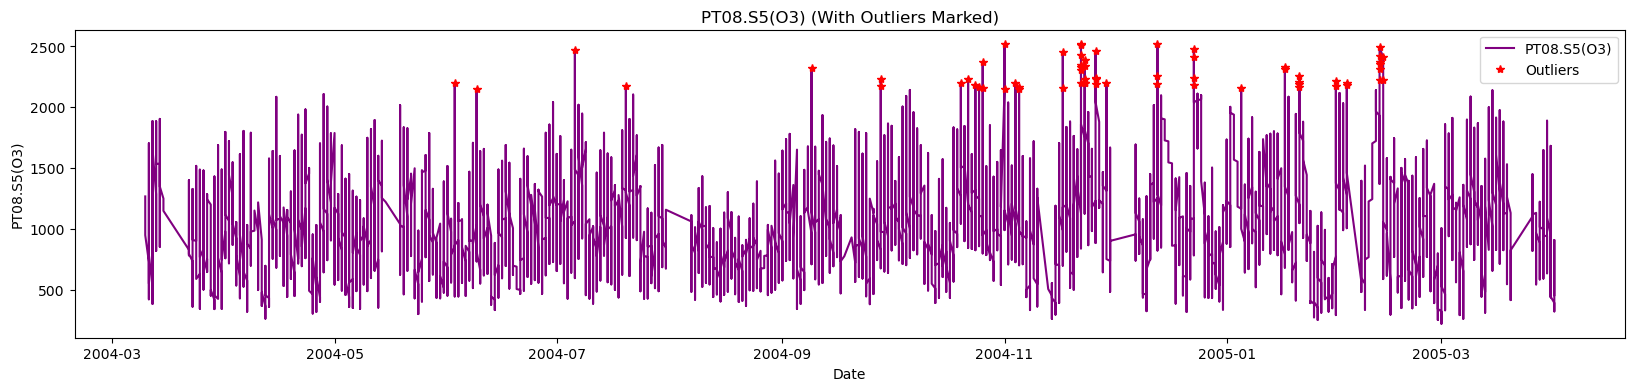

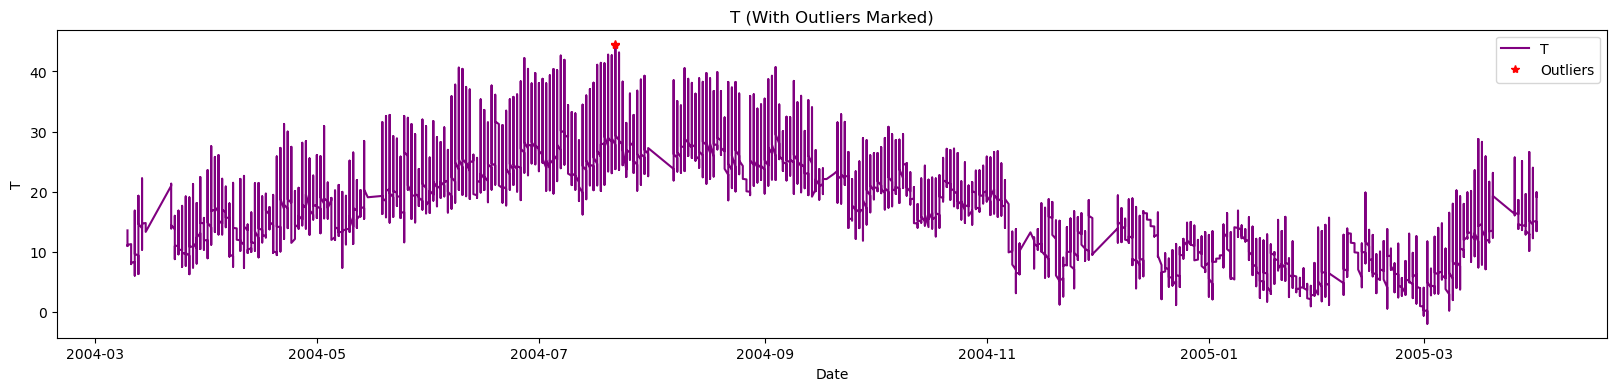

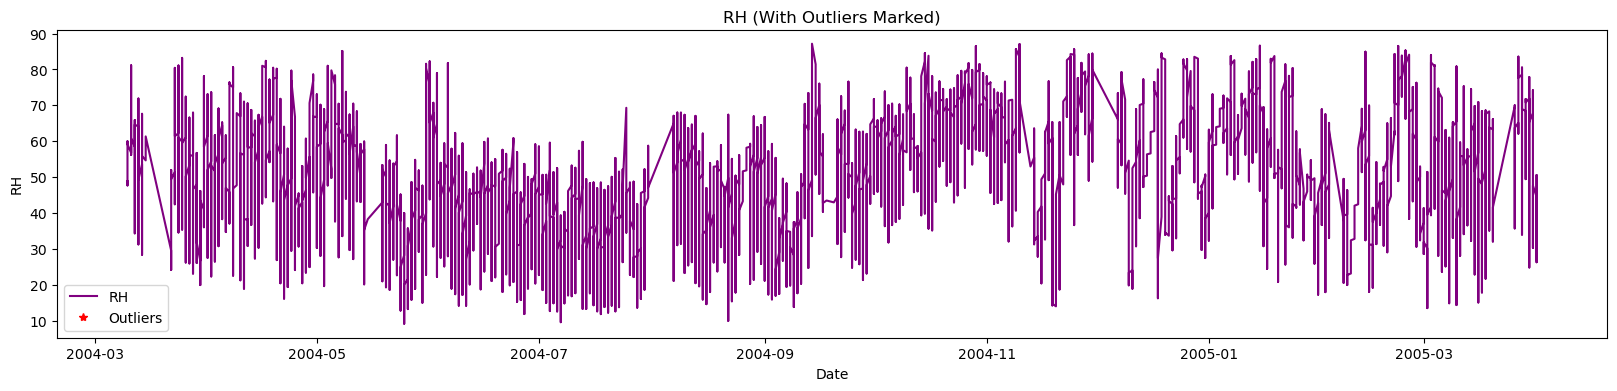

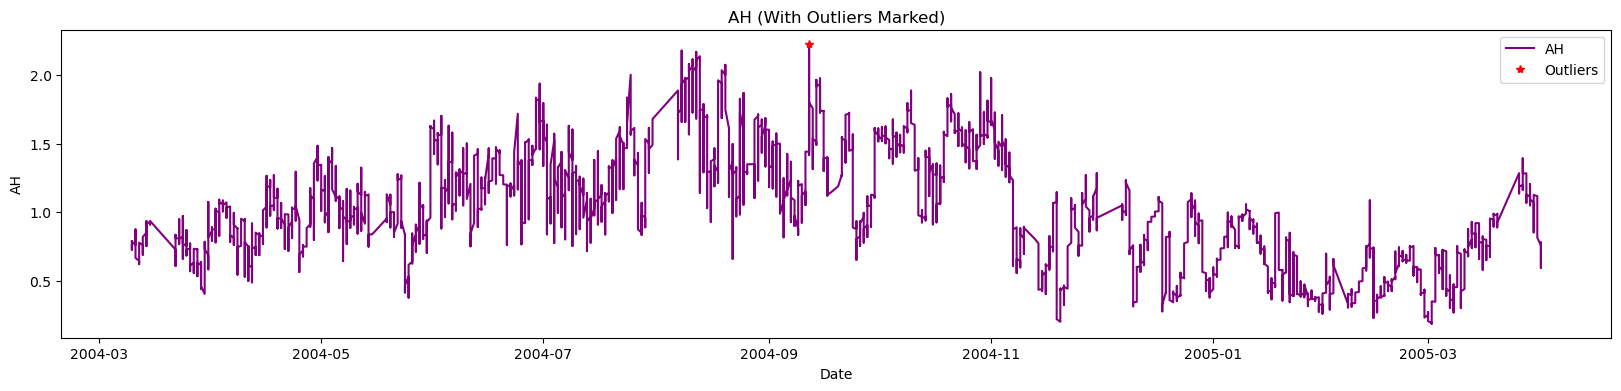

In [6]:
# Detect outliers using IQR
Q1 = data_interpolated.quantile(0.25)
Q3 = data_interpolated.quantile(0.75)
IQR = Q3 - Q1

# Define outliers as points outside 1.5*IQR range
outliers_lower_bound = Q1 - 1.5 * IQR
outliers_upper_bound = Q3 + 1.5 * IQR

# Logging all the outliers
outliers = (data_interpolated < outliers_lower_bound) | (data_interpolated > outliers_upper_bound)

# Plot data with outliers marked
for column in data_interpolated.columns:
    plt.figure(figsize=(20, 4))
    plt.plot(data_interpolated[column], label=column, color='purple')
    plt.plot(data_interpolated[column][outliers[column]], 'r*', label='Outliers')
    plt.title(f'{column} (With Outliers Marked)')
    plt.xlabel('Date')
    plt.ylabel(column)
    plt.legend()
    plt.show()
    
# Replace outliers with NaN
data_interpolated[outliers] = np.nan

# Fill NaN values resulted from outliers detection using linear interpolation
data_cleaned = data_interpolated.interpolate(method='linear', limit_direction='forward', axis=0)

# data_cleaned = data_interpolated


## Classification task

### Step 1: Create target variable

In [7]:
# Calculate the mean value for CO(GT), excluding missing values
co_mean = data_cleaned['CO(GT)'].mean()

# Create the binary target variable CO_Target in the data_cleaned DataFrame
# It assigns a value of 1 to the CO_Target column
# if the corresponding value in the CO(GT) column is greater than the calculated mean (co_mean), and 0 otherwise
data_cleaned['CO_Target'] = (data_cleaned['CO(GT)'] > co_mean).astype(int)


### Step 2: Compute and Plot Correlation Matrix for Feature selection

#### Since NMHC(GT) has too many missing values the acutal valid values are now outliers so I dropped this feature in the future process

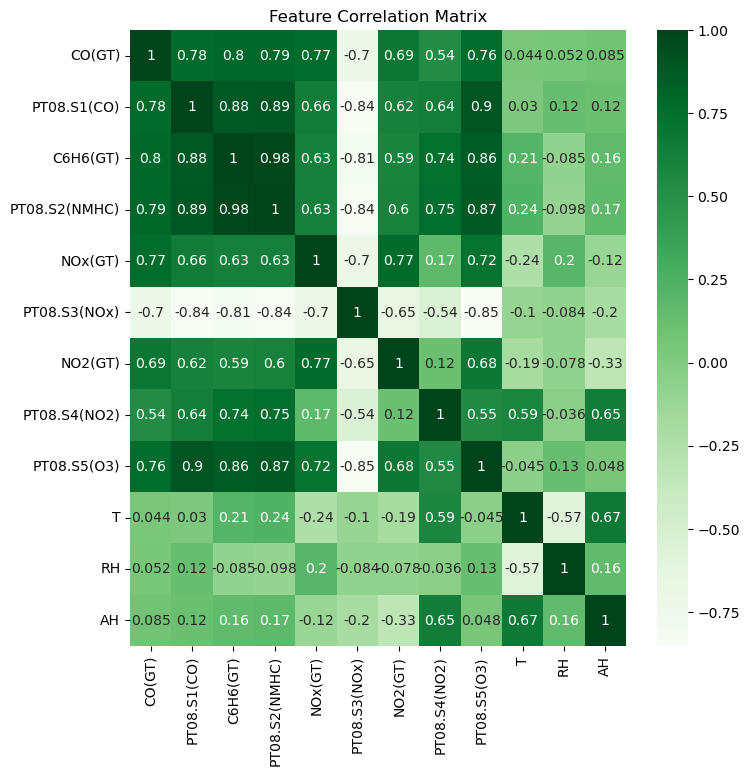

In [8]:
# Compute and plot the correlation matrix
plt.figure(figsize=(8, 8))
corr_matrix = data_cleaned.drop(columns=['NMHC(GT)', 'CO_Target']).corr()
sns.heatmap(corr_matrix, annot=True, cmap='Greens')
plt.title('Feature Correlation Matrix')
plt.show()

### Step 3: Prepare Features and Target

Feture engineering:

Rolling statistics here are a way to calculate statistics over a moving window of a fixed size across a time series data. 
This technique is particularly useful for capturing temporal trends and patterns over time. 

Here, it calculates two new rolling statistics with a window size of 24.

Rolling Mean: it calculates the mean of the current and previous 23 values for each entry in the column. The result is a new column named f'{col}_rolling_mean'.

Rolling Standard Deviation: it calculates the standard deviation of the current and previous 23 values for each entry in the column. The result is a new column named f'{col}_rolling_std'.

The dropped features are:

'CO(GT)' and 'CO_Target': These are the target variable and its binary representation, which should not be part of the features.

'NMHC(GT)': Dropped due to massive missing values.

'T', 'RH', 'AH': These features were dropped based on their correlation with the target variable and other features.


In [9]:
# Feature Engineering
# Rolling statistics
for col in data_cleaned.columns:
    if col not in ['CO(GT)', 'CO_Target', 'NMHC(GT)', 'T', 'RH', 'AH']:
        data_cleaned[f'{col}_rolling_mean'] = data_cleaned[col].rolling(window=24).mean()
        data_cleaned[f'{col}_rolling_std'] = data_cleaned[col].rolling(window=24).std()

# Drop rows with NaN values created by rolling statistics
data_cleaned.dropna(inplace=True)

# Prepare the features (X) and target (y)
# X = data_cleaned.drop(columns=['CO(GT)', 'CO_Target', 'NMHC(GT)', 'PT08.S4(NO2)', 'T', 'RH', 'AH'])
X = data_cleaned.drop(columns=['CO(GT)', 'CO_Target', 'NMHC(GT)', 'T', 'RH', 'AH'])

y = data_cleaned['CO_Target']


### Step 4: Split and Standardize Data [Answering 2.1 (d)]

### Train size: 70%, Validation size: 15%, Test size: 15%.

In [10]:
# Split the data into training and combined validation/test sets
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3)

# Further split the combined set into validation and test sets
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5)

# Standardize the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)

print(f"Mean value for CO(GT): {co_mean}")
print(f"Total data size: {X.shape}")
print(f"Training data size: {X_train.shape}")
print(f"Validation data size: {X_val.shape}")
print(f"Testing data size: {X_test.shape}")

Mean value for CO(GT): 2.090075376884422
Total data size: (7308, 24)
Training data size: (5115, 24)
Validation data size: (1096, 24)
Testing data size: (1097, 24)


### Step 5: Build and Train the Neural Network [Answering 2.2, 2.3, 2.4(a)]

### Total Number of Layers: 5 (excluding the input layer)

Dense Layer 1: `64` units, ReLU activation

Dropout Layer 1: `0.3` dropout rate

Dense Layer 2: `16` units, ReLU activation

Dropout Layer 2: `0.2` dropout rate

Output Layer: `1` unit, Sigmoid activation

### Dropout Rate:

Higher Dropout Rate: More neurons dropped, stronger regularization, higher risk of underfitting.

Lower Dropout Rate: Fewer neurons dropped, weaker regularization, higher risk of overfitting.

### L2 Regularization 

`0.001`
By adding a penalty for large weights, L2 regularization helps to prevent the model from fitting the training data too closely, which can lead to better generalization on unseen data.

### Training Parameters

Loss Function: `binary_crossentropy`
This loss function is used for binary classification problems, where the goal is to predict one of two possible outcomes.

#### Optimizer: 

Adam: `Adam` (Adaptive Moment Estimation) optimizer is used for both tasks.

Combines the advantages of two other extensions of stochastic gradient descent. Specifically, it uses adaptive learning rates and momentum.

#### Learning Rate:

`lr = 0.0012` Controls the step size during the optimization process. A smaller learning rate can lead to more precise convergence but may require more epochs to train.

#### Batch Size: 

`64`
The number of training samples used in one forward and backward pass. A smaller batch size requires less memory and provides more updates to the model weights, while a larger batch size provides a more accurate estimate of the gradient but requires more memory.

#### Epochs: 
`150`
The number of times the entire training dataset is passed forward and backward through the neural network. More epochs can lead to better training but also increase the risk of overfitting.

### Check Possible Overfitting

`Verify the Training and Validation Accuracy, If the training accuracy continues to increase while the validation accuracy starts to plateau or decrease, it indicates overfitting.`

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 64)             │         1,600 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 16)             │         1,040 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 16)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1)              │            17 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,657 (10.38 KB)

 Trainable params: 2,657 (10.38 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/150
80/80 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.7063 - loss: 0.5959 - val_accuracy: 0.8814 - val_loss: 0.3711
Epoch 2/150
80/80 ━━━━━━━━━━━━━━━━━━━━ 0s 555us/step - accuracy: 0.8878 - loss: 0.3778 - val_accuracy: 0.8823 - val_loss: 0.3376
Epoch 3/150
80/80 ━━━━━━━━━━━━━━━━━━━━ 0s 555us/step - accuracy: 0.8915 - loss: 0.3356 - val_accuracy: 0.8942 - val_loss: 0.3117
Epoch 4/150
80/80 ━━━━━━━━━━━━━━━━━━━━ 0s 536us/step - accuracy: 0.8960 - loss: 0.3173 - val_accuracy: 0.9042 - val_loss: 0.2966
Epoch 5/150
80/80 ━━━━━━━━━━━━━━━━━━━━ 0s 543us/step - accuracy: 0.9026 - loss: 0.3043 - val_accuracy: 0.9042 - val_loss: 0.2880
Epoch 6/150
80/80 ━━━━━━━━━━━━━━━━━━━━ 0s 569us/step - accuracy: 0.8968 - loss: 0.3144 - val_accuracy: 0.9106 - val_loss: 0.2803
Epoch 7/150
80/80 ━━━━━━━━━━━━━━━━━━━━ 0s 624us/step - accuracy: 0.9049 - loss: 0.3012 - val_accuracy: 0.9088 - val_loss: 0.2759
Epoch 8/150
80/80 ━━━━━━━━━━━━━━━━━━━━ 0s 626us/step - accuracy: 0.9002 - loss: 0.2912 - val_accura

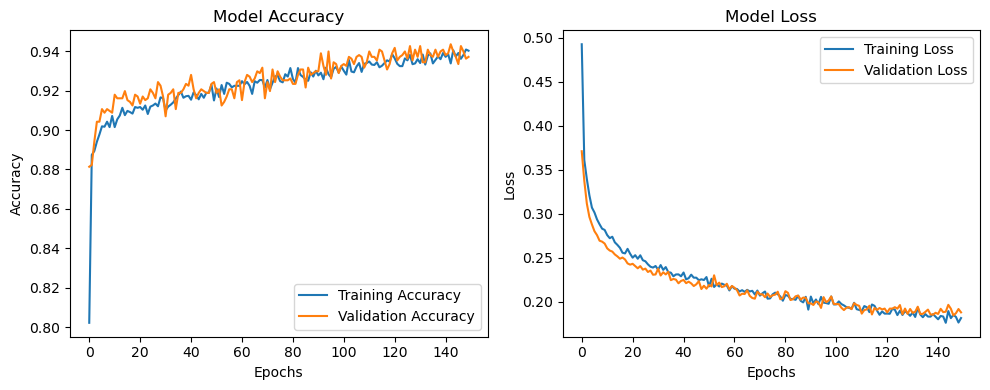

In [11]:
# Build the neural network
classification_model = Sequential([
    Input(shape=(X_train_scaled.shape[1],)),
    Dense(64, activation='relu', kernel_regularizer=l2(0.001)),
    Dropout(0.3),
    Dense(16, activation='relu', kernel_regularizer=l2(0.001)),
    Dropout(0.2),
    Dense(1, activation='sigmoid')
])

# Compile the model
classification_model.compile(optimizer=Adam(learning_rate=0.0012), loss='binary_crossentropy', metrics=['accuracy'])

# Show the maximal number of parameters
classification_model.summary()

# Train the neural network
history = classification_model.fit(X_train_scaled, y_train, epochs=150, batch_size=64, validation_data=(X_val_scaled, y_val))

# Plot combined training history
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 4))

# Plot accuracy
ax1.plot(history.history['accuracy'], label='Training Accuracy')
ax1.plot(history.history['val_accuracy'], label='Validation Accuracy')
ax1.set_title('Model Accuracy')
ax1.set_xlabel('Epochs')
ax1.set_ylabel('Accuracy')
ax1.legend()

# Plot loss
ax2.plot(history.history['loss'], label='Training Loss')
ax2.plot(history.history['val_loss'], label='Validation Loss')
ax2.set_title('Model Loss')
ax2.set_xlabel('Epochs')
ax2.set_ylabel('Loss')
ax2.legend()

plt.tight_layout()
plt.show()

# Save the classification model
classification_model.save('classification_model.keras')

### Step 6: Evaluate the Model [Answering 2.4(b)]

35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 330us/step - accuracy: 0.9390 - loss: 0.1909
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 598us/step
                 Metric     Value
0   True Positives (TP)       453
1  False Positives (FP)        40
2   True Negatives (TN)       573
3  False Negatives (FN)        31
4              Accuracy  93.5278%
5             Precision  91.8864%


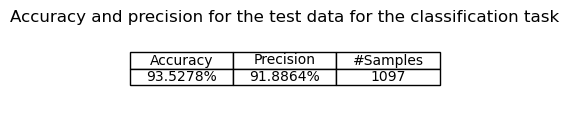

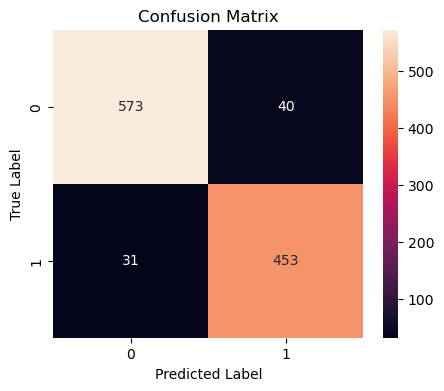

In [12]:
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score

# Evaluate and Predict the model on the test set
# Threshold has been set to 0.5 since this is a binary classification
test_loss, test_accuracy = classification_model.evaluate(X_test_scaled, y_test)
y_test_pred = (classification_model.predict(X_test_scaled) > 0.5).astype(int)

# Generate the confusion matrix
conf_matrix = confusion_matrix(y_test, y_test_pred)

# Extract TP, FP, TN, FN from the confusion matrix
tn, fp, fn, tp = conf_matrix.ravel()

# Calculate accuracy
accuracy = accuracy_score(y_test, y_test_pred)

# Calculate precision
precision = precision_score(y_test, y_test_pred)

# Number of samples
n_samples = len(y_test)

# Display the results in a table
classification_results = pd.DataFrame(
    {
        "Metric": [
            "True Positives (TP)",
            "False Positives (FP)",
            "True Negatives (TN)",
            "False Negatives (FN)",
            "Accuracy",
            "Precision",
        ],
        "Value": [tp, fp, tn, fn, f"{accuracy * 100:.4f}%", f"{precision * 100:.4f}%"],
    }
)

print(classification_results)

fig, ax = plt.subplots(figsize=(4, 1))

ax.xaxis.set_visible(False)
ax.yaxis.set_visible(False)
ax.set_frame_on(False)

table = ax.table(
    cellText=[[f"{accuracy * 100:.4f}%", f"{precision * 100:.4f}%", n_samples]],
    colLabels=["Accuracy", "Precision", "#Samples"],
    cellLoc="center",
    loc="center",
)

plt.title(
    "Accuracy and precision for the test data for the classification task", fontsize=12
)
plt.show()

# Plot the confusion matrix
plt.figure(figsize=(5, 4))
sns.heatmap(conf_matrix, annot=True, fmt="d")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()

In [13]:
# Code Dilimiter
pass

## Regression Task

### Step 1: Reading and Preproccess the data like above

                               Min                  Max
Date           2004-03-10 00:00:00  2005-04-01 00:00:00
Time                      00:00:00             23:00:00
CO(GT)                      -200.0                 11.9
PT08.S1(CO)                 -200.0              2007.75
NMHC(GT)                      -200                 1189
C6H6(GT)                    -200.0            63.741476
PT08.S2(NMHC)               -200.0               2214.0
NOx(GT)                     -200.0               1479.0
PT08.S3(NOx)                -200.0              2682.75
NO2(GT)                     -200.0                339.7
PT08.S4(NO2)                -200.0               2775.0
PT08.S5(O3)                 -200.0              2522.75
T                           -200.0                 44.6
RH                          -200.0            87.174999
AH                          -200.0             2.231036
Tally of missing value (-200):
CO(GT)           1585
PT08.S1(CO)       366
NMHC(GT)         7525
C6H6(GT

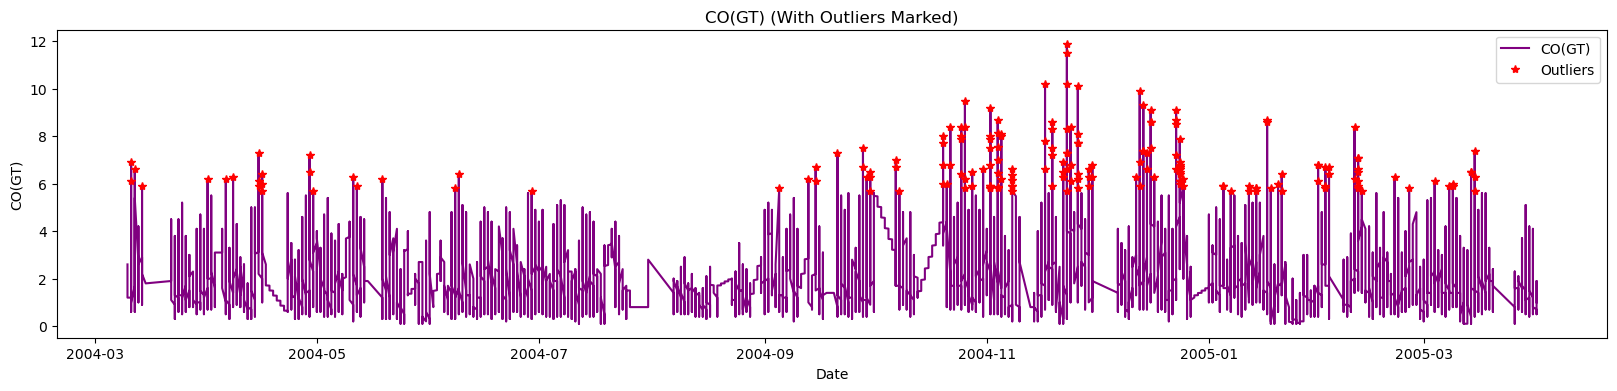

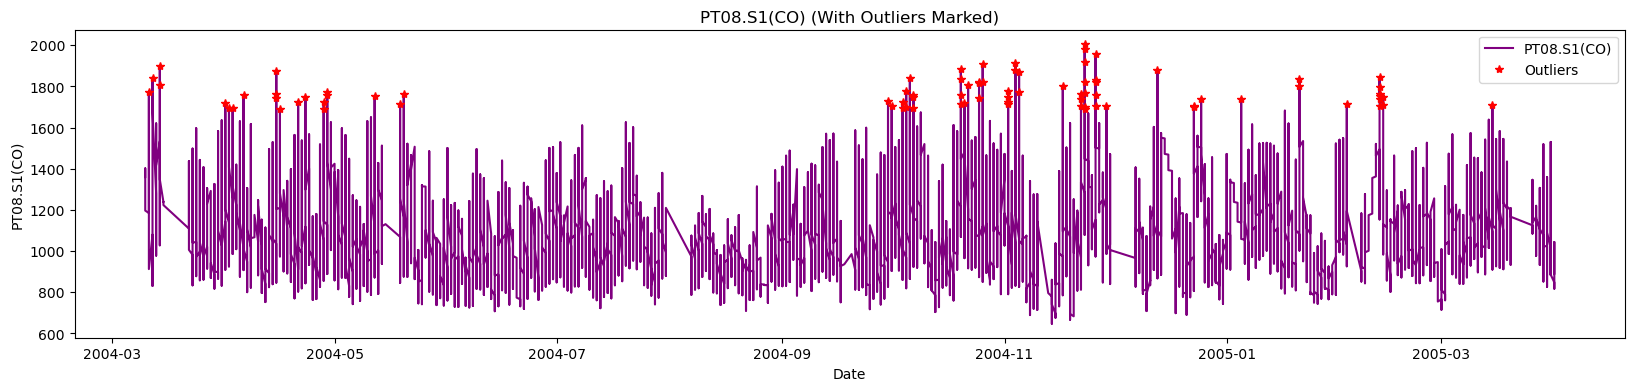

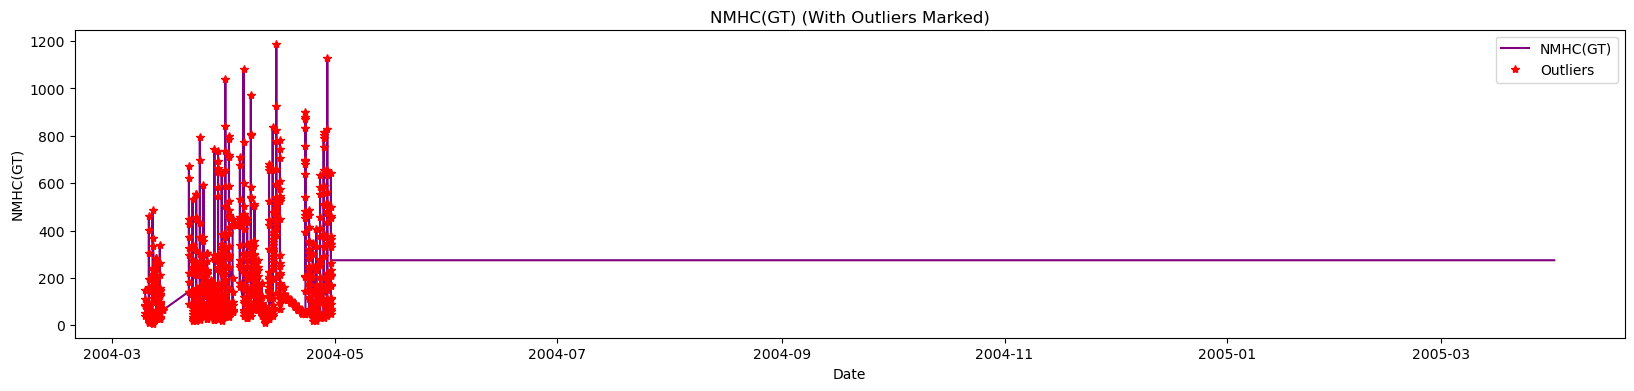

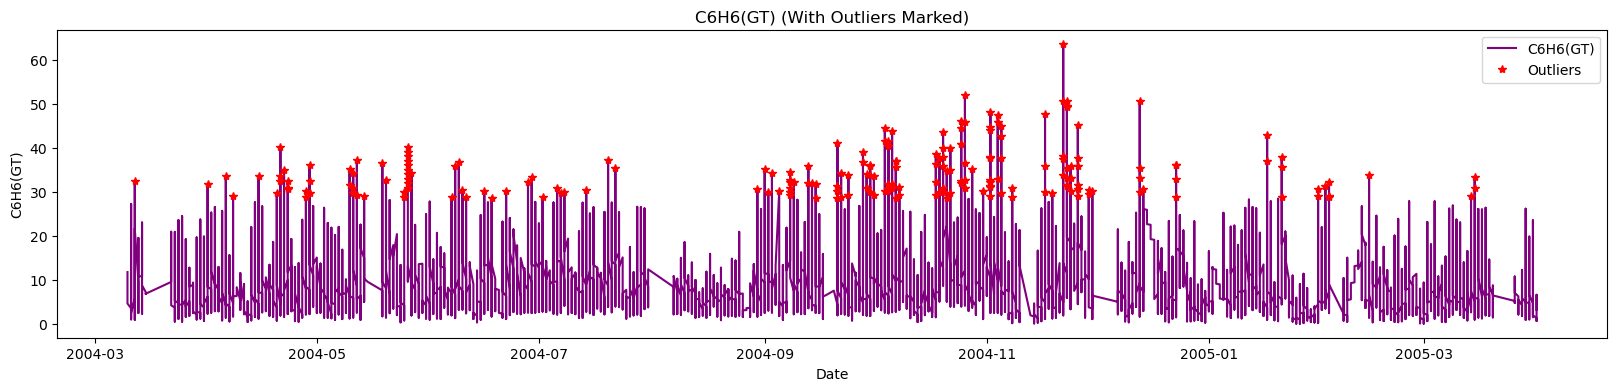

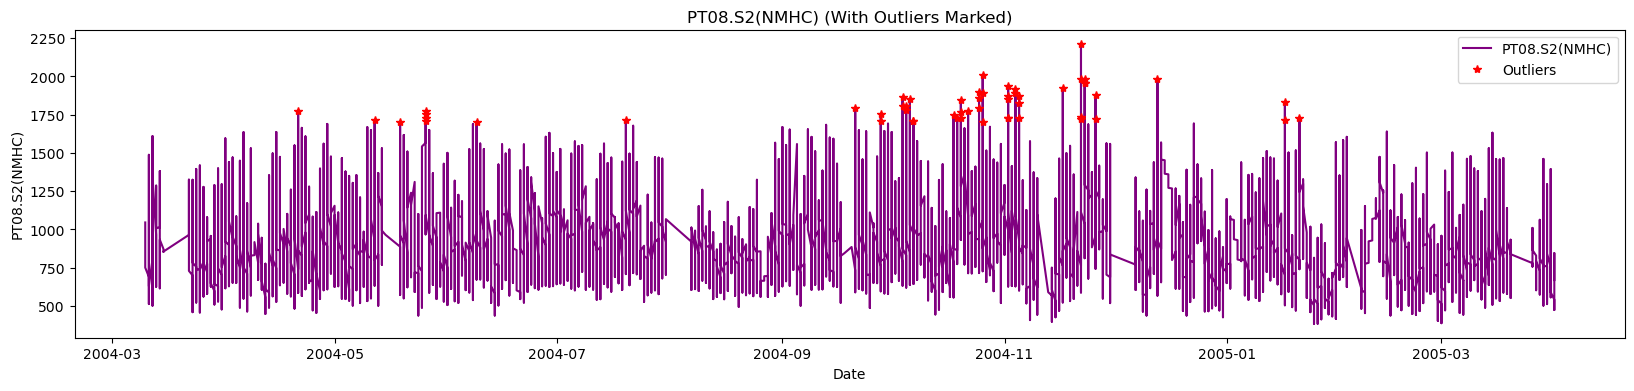

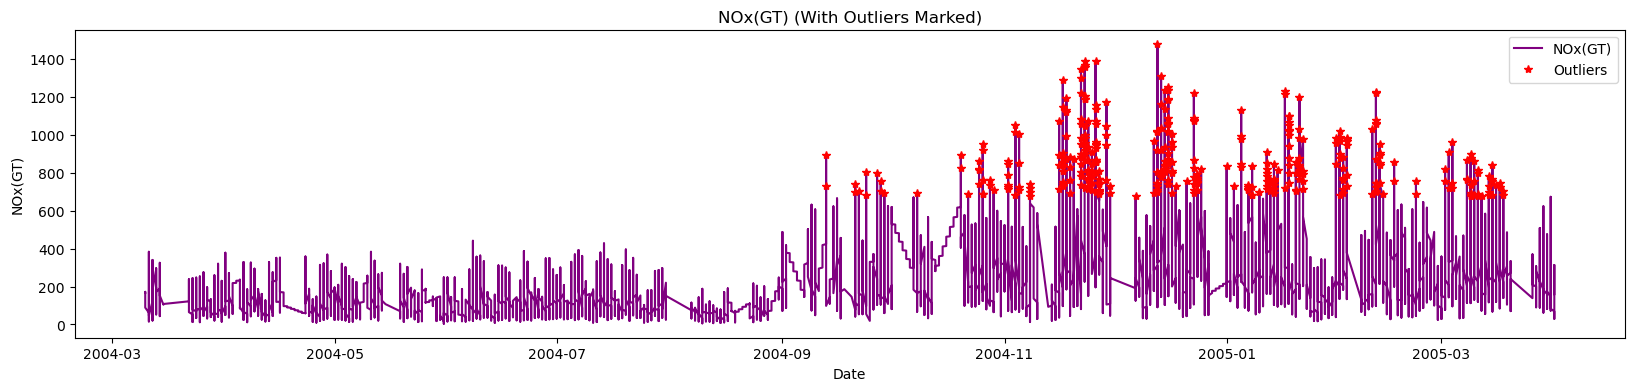

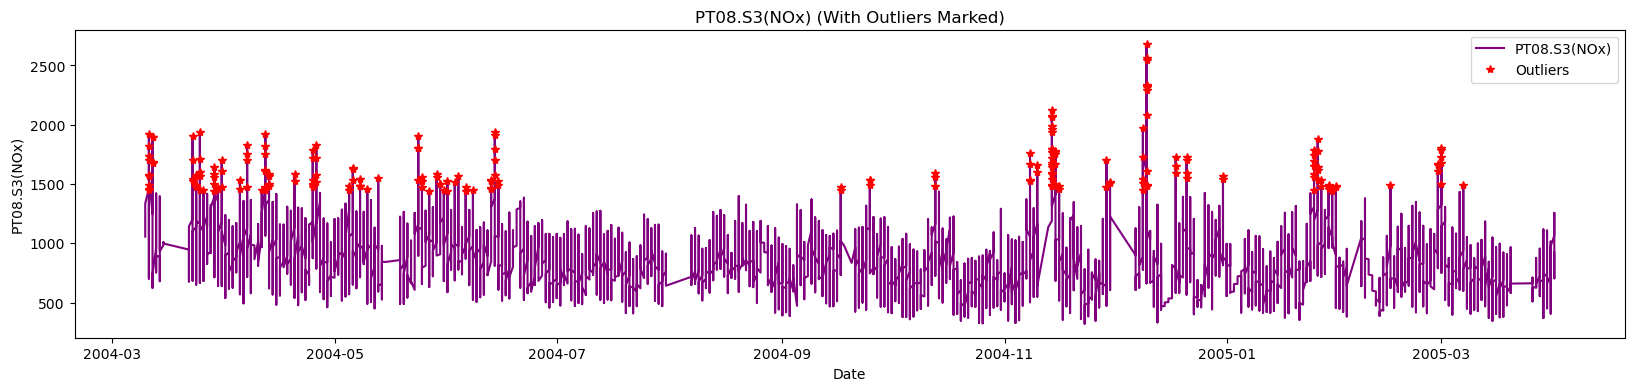

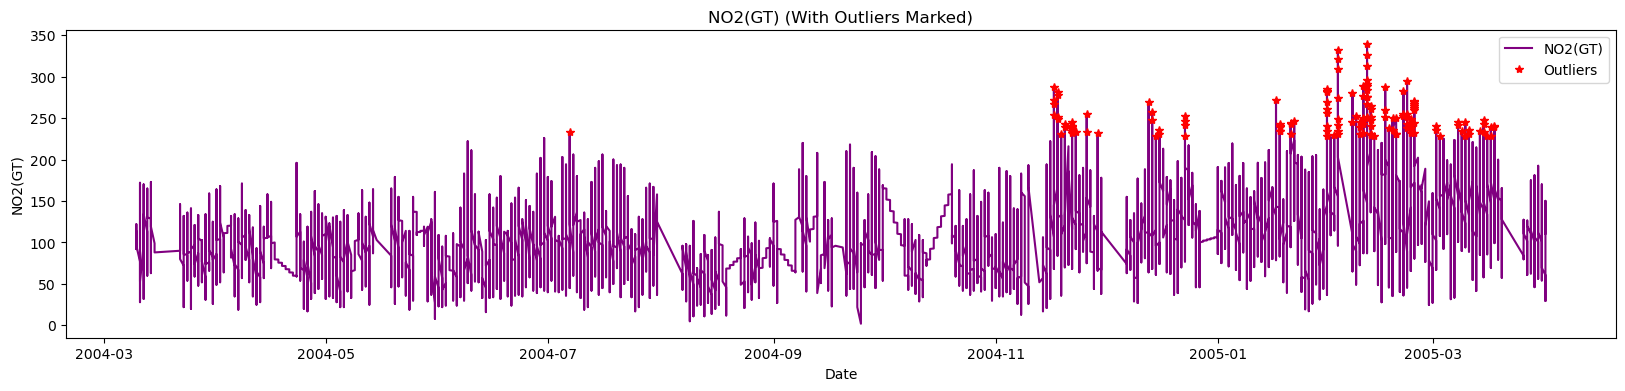

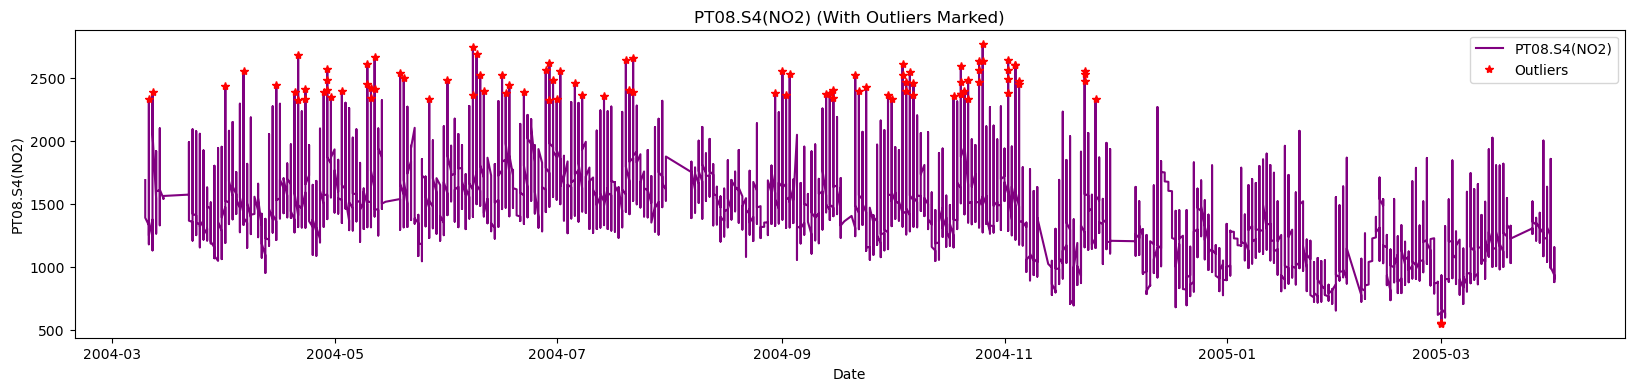

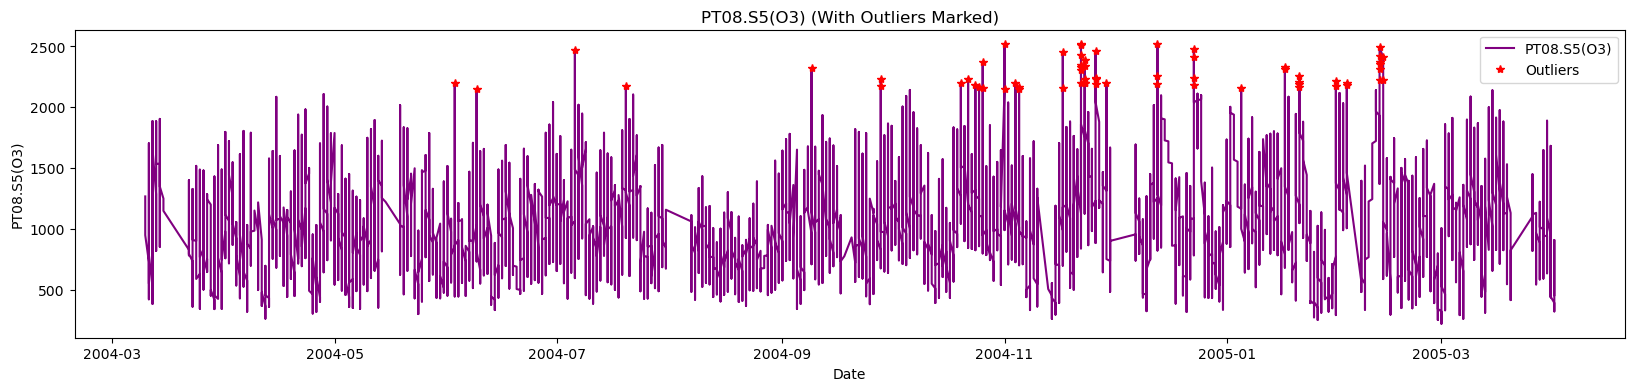

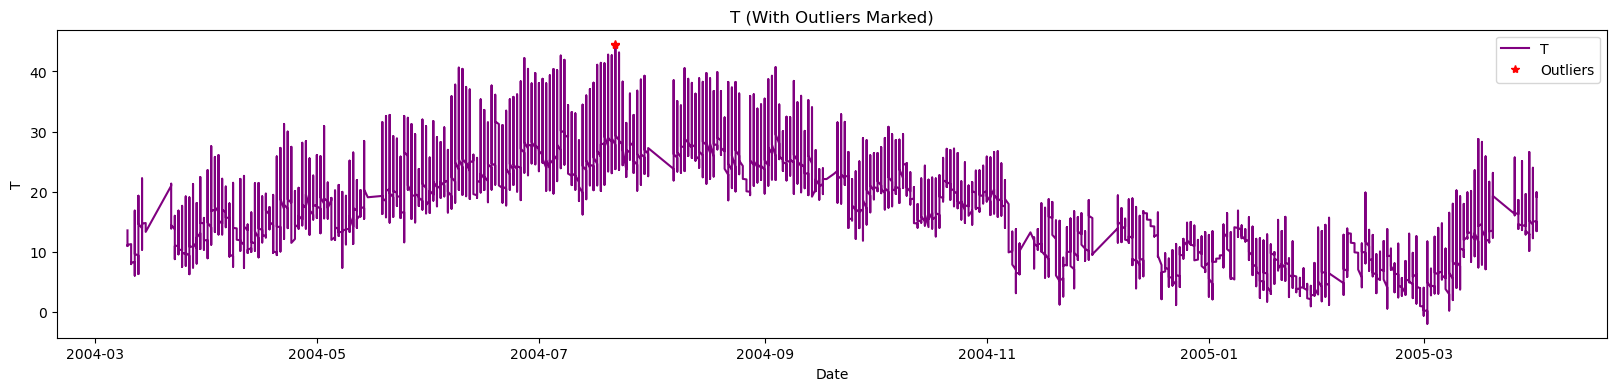

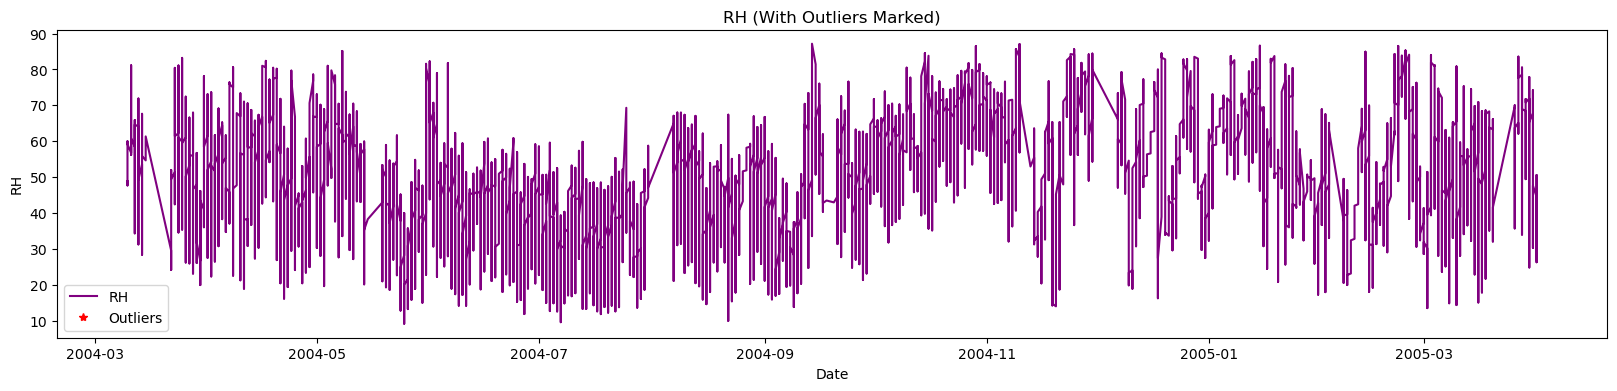

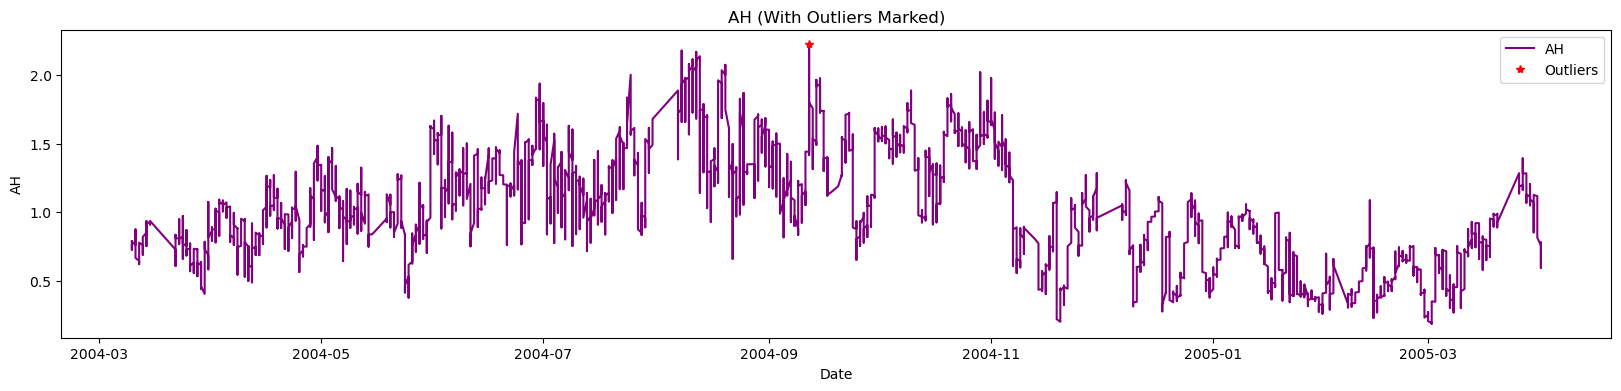

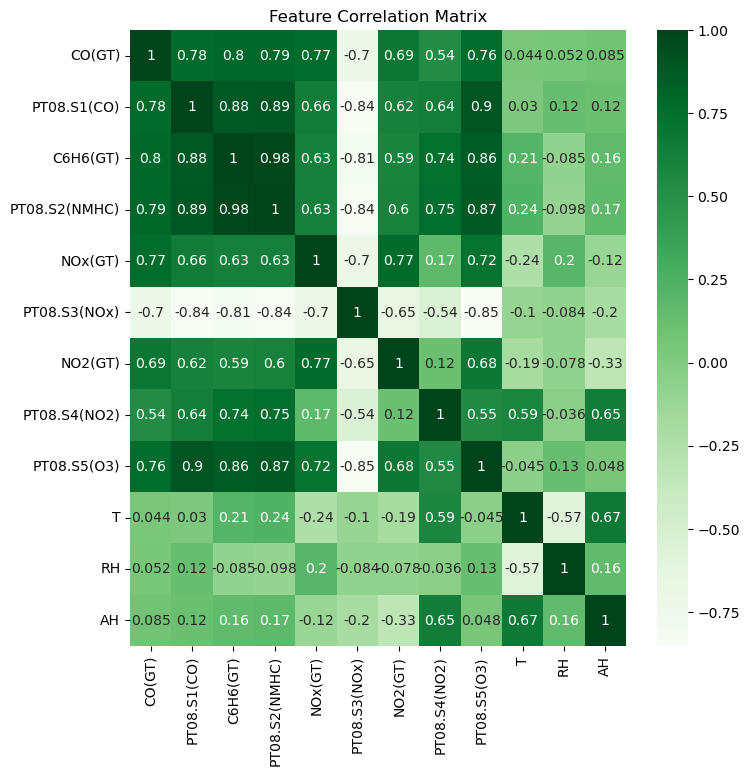

In [14]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error
import tensorflow as tf
import seaborn as sns
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Dense, Dropout, Input
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l2

# Read data from the given xlsx file
AQ_file = 'AirQualityUCI _ Students.xlsx'
AQ_data = pd.read_excel(AQ_file)

# Calculate the minimum and maximum values of each column and create a DataFrame to display the results
min_max_df = pd.DataFrame({'Min': AQ_data.min(), 'Max': AQ_data.max()})

print(min_max_df)
# min_max_df

# Convert Date column to datetime
AQ_data['Date'] = pd.to_datetime(AQ_data['Date'])

# Set Date as the index
AQ_data.set_index('Date', inplace=True)

# Drop the Time column
AQ_data.drop(columns=['Time'], inplace=True)

# Checking missing value
# Since stated in the Problem context, the missing value has been tagget with -200
# Hence, replace -200 with NaN for missing data
# Count the occurrences of -200 in each column
missing_value_tally = (AQ_data == -200).sum()
print("Tally of missing value (-200):")
print(missing_value_tally)
data_replaced = AQ_data.replace(-200, np.nan)

# Handle missing data using linear interpolation
data_interpolated = data_replaced.interpolate(method='linear', limit_direction='forward', axis=0)

# Detect outliers using IQR
Q1 = data_interpolated.quantile(0.25)
Q3 = data_interpolated.quantile(0.75)
IQR = Q3 - Q1

# Define outliers as points outside 1.5*IQR range
outliers_lower_bound = Q1 - 1.5 * IQR
outliers_upper_bound = Q3 + 1.5 * IQR

# Logging all the outliers
outliers = (data_interpolated < outliers_lower_bound) | (data_interpolated > outliers_upper_bound)

# Plot data with outliers marked
for column in data_interpolated.columns:
    plt.figure(figsize=(20, 4))
    plt.plot(data_interpolated[column], label=column, color='purple')
    plt.plot(data_interpolated[column][outliers[column]], 'r*', label='Outliers')
    plt.title(f'{column} (With Outliers Marked)')
    plt.xlabel('Date')
    plt.ylabel(column)
    plt.legend()
    plt.show()

# data_cleaned = data_interpolated
# Replace outliers with NaN
data_interpolated[outliers] = np.nan

# Fill NaN values resulted from outliers detection using linear interpolation
data_cleaned = data_interpolated.interpolate(method='linear', limit_direction='forward', axis=0)

# Calculate the mean value for CO(GT), excluding missing values
co_mean = data_cleaned['CO(GT)'].mean()

# Since NMHC(GT) has too many missing values
# the acutal valid values are now outliers
# so we dropped this feature in the future process
# Compute and plot the correlation matrix
plt.figure(figsize=(8, 8))
corr_matrix = data_cleaned.drop(columns='NMHC(GT)').corr()
sns.heatmap(corr_matrix, annot=True, cmap='Greens')
plt.title('Feature Correlation Matrix')
plt.show()


### Step 2 & 3: Split Data, Prepare Features, Target and Standardize the Data

### Train size: 70%, Validation size: 15%, Test size: 15%.

The dropped features are:

'NOx(GT)': The target variable.

'NMHC(GT)', 'PT08.S4(NO2)',  'T', 'RH', 'AH': These features were dropped based on their correlation.

In [15]:
# Split the data
n = len(data_cleaned)
train_size = int(n * 0.7)
val_size = int(n * 0.15)

train_data = data_cleaned[:train_size]
val_data = data_cleaned[train_size:train_size + val_size]
test_data = data_cleaned[train_size + val_size:]

# Drop features and create target
X_train = train_data.drop(columns=['NOx(GT)', 'NMHC(GT)', 'PT08.S4(NO2)', 'T', 'RH', 'AH'])
y_train = train_data['NOx(GT)']
X_val = val_data.drop(columns=['NOx(GT)', 'NMHC(GT)', 'PT08.S4(NO2)', 'T', 'RH', 'AH'])
y_val = val_data['NOx(GT)']
X_test = test_data.drop(columns=['NOx(GT)', 'NMHC(GT)', 'PT08.S4(NO2)', 'T', 'RH', 'AH'])
y_test = test_data['NOx(GT)']

# Standardize the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)

### Step 4: Build and Train the Neural Network

#### Total Number of Layers: 5 (excluding the input layer)

Dense Layer 1: `32` units, ReLU activation

Dropout Layer 1: `0.5` dropout rate

Dense Layer 2: `16` units, ReLU activation

Dropout Layer 2: `0.5` dropout rate

Output Layer: `1` unit, linear activation

### Dropout Rate:

Higher Dropout Rate: More neurons dropped, stronger regularization, higher risk of underfitting.

Lower Dropout Rate: Fewer neurons dropped, weaker regularization, higher risk of overfitting.

### L2 Regularization 

`0.01`
By adding a penalty for large weights, L2 regularization helps to prevent the model from fitting the training data too closely, which can lead to better generalization on unseen data.


### Training Parameters

Loss Function: `mean_squared_error`
This loss function measures the average squared difference between the actual and predicted values, commonly used in regression problems.

#### Optimizer: 

Adam: `Adam` (Adaptive Moment Estimation) optimizer is used for both tasks.

Combines the advantages of two other extensions of stochastic gradient descent. Specifically, it uses adaptive learning rates and momentum.

#### Learning Rate:

`lr = 0.001` Controls the step size during the optimization process. A smaller learning rate can lead to more precise convergence but may require more epochs to train.

#### Batch Size: 

`64`
The number of training samples used in one forward and backward pass. A smaller batch size requires less memory and provides more updates to the model weights, while a larger batch size provides a more accurate estimate of the gradient but requires more memory.

#### Epochs: 
`100`
The number of times the entire training dataset is passed forward and backward through the neural network. More epochs can lead to better training but also increase the risk of overfitting.

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_3 (Dense)                 │ (None, 32)             │           256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 16)             │           528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 16)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 1)              │            17 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 801 (3.13 KB)

 Trainable params: 801 (3.13 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/100
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 61553.3867 - mae: 194.9862 - val_loss: 127764.2266 - val_mae: 314.1122
Epoch 2/100
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 560us/step - loss: 56309.1289 - mae: 184.6492 - val_loss: 109803.7109 - val_mae: 290.4947
Epoch 3/100
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 548us/step - loss: 46862.9961 - mae: 164.8429 - val_loss: 69975.9375 - val_mae: 231.1930
Epoch 4/100
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 563us/step - loss: 29353.3848 - mae: 125.5053 - val_loss: 37724.3789 - val_mae: 167.7085
Epoch 5/100
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 514us/step - loss: 22145.1211 - mae: 107.3039 - val_loss: 28362.0938 - val_mae: 143.8550
Epoch 6/100
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 484us/step - loss: 19503.3633 - mae: 100.4511 - val_loss: 22714.2012 - val_mae: 127.4551
Epoch 7/100
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 482us/step - loss: 18629.7969 - mae: 96.9599 - val_loss: 18079.9336 - val_mae: 111.9718
Epoch 8/100
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 477us/step - loss: 15648.2793 - mae: 88.69

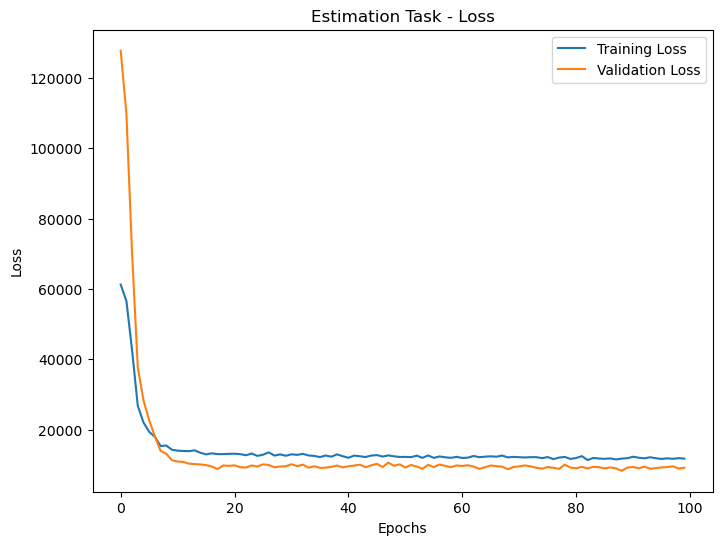

In [16]:
# Build the neural network
regression_model = Sequential([
    Input(shape=(X_train_scaled.shape[1],)),
    Dense(32, activation='relu', kernel_regularizer=l2(0.01)),
    Dropout(0.5),
    Dense(16, activation='relu', kernel_regularizer=l2(0.01)),
    Dropout(0.5),
    Dense(1, activation='linear')
])

# Compile the model
regression_model.compile(optimizer=Adam(learning_rate=0.001), loss='mean_squared_error', metrics=['mae'])

# Print the model summary
regression_model.summary()

# Train the neural network
history = regression_model.fit(X_train_scaled, y_train, epochs=100, batch_size=64, validation_data=(X_val_scaled, y_val))

# Plot training history
plt.figure(figsize=(8, 6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Estimation Task - Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Save the model
regression_model.save('regression_model.keras')

### Step 5: Evaluate the Model [Answering 2.4(c)(d)]

#### Check Possible Overfitting
`Verify the Training and Validation Loss, If the training loss continues to decrease while the validation loss starts to increase, it indicates overfitting.`


40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 287us/step - loss: 5058.7817 - mae: 55.3928
Test Mean Absolute Error: 47.9600
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 544us/step


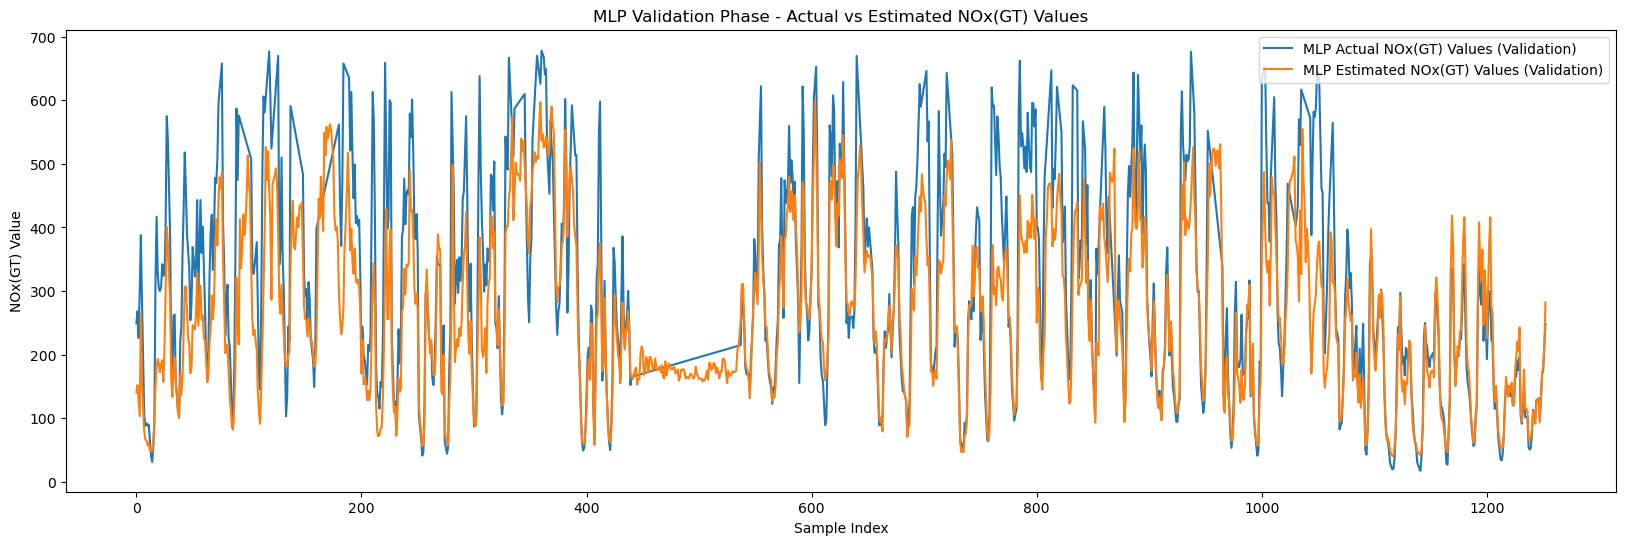

40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 306us/step
      RMSE      MAE  #Samples
0  63.7866  47.9600      1255


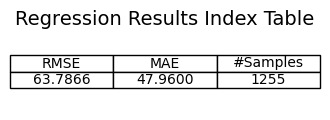

In [17]:
# Evaluate the regression model on the test set
test_loss, test_mae = regression_model.evaluate(X_test_scaled, y_test)
print(f"Test Mean Absolute Error: {test_mae:.4f}")

# Predict NOx concentrations on the validation set
y_val_pred = regression_model.predict(X_val_scaled)

# Plot true vs predicted NOx concentrations
plt.figure(figsize=(20, 6))
plt.plot(y_val.values, label='MLP Actual NOx(GT) Values (Validation)')
plt.plot(y_val_pred, label='MLP Estimated NOx(GT) Values (Validation)')
plt.title('MLP Validation Phase - Actual vs Estimated NOx(GT) Values')
plt.xlabel('Sample Index')
plt.ylabel('NOx(GT) Value')
plt.legend()
plt.show()

# Predict NOx concentrations on the test set
y_test_pred = regression_model.predict(X_test_scaled)

# Calculate RMSE and MAE of the test set
rmse = np.sqrt(mean_squared_error(y_test, y_test_pred))

mae = mean_absolute_error(y_test, y_test_pred)

# Number of samples
n_samples = len(y_test)

# Create a DataFrame to display the performace indexes table
regression_results_index_table = pd.DataFrame({
    'RMSE': [f'{rmse:.4f}'],
    'MAE': [f'{mae:.4f}'],
    '#Samples': [n_samples]
})

print(regression_results_index_table)

fig, ax = plt.subplots(figsize=(4, 1))

ax.xaxis.set_visible(False)
ax.yaxis.set_visible(False)
ax.set_frame_on(False)

regression_index_table = ax.table(cellText=regression_results_index_table.values,
                 colLabels=regression_results_index_table.columns,
                 cellLoc='center', 
                 loc='center')

plt.title('Regression Results Index Table', fontsize=14)
plt.show()

`Ref:`

[1] Dekking, Frederik Michel; Kraaikamp, Cornelis; Lopuhaä, Hen Paul; Meester, Ludolf Erwin (2005). A Modern Introduction to Probability and Statistics. Springer Texts in Statistics. London: Springer London. doi:10.1007/1-84628-168-7. ISBN 978-1-85233-896-1.